In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import glob
import os
import csv

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import load_model
%matplotlib inline

C:\Users\asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

In [14]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('../Data set/FIXED_SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        for row in file_data:
            if row[1] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                stock_data.append([float(row[1])])
                
    return stock_data

In [15]:
stock_datas = [ load_stock_data(x, 2008, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

In [17]:
rounds = min_count - 30
train_index = int(rounds * 0.7)

In [18]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_test = x[train_index: train_index+1].astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2] * x_train.shape[3]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2] * x_test.shape[3]))

print(x_train.shape, x_test.shape)

(1811, 36, 30) (120, 36, 30) (1, 36, 30)


In [19]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_test = y[train_index: rounds].astype('float32')

print(y_train.shape, y_test.shape)

(1811, 36) (120, 36) (484, 36)


In [24]:
neurons = 512        
activation_function = 'tanh'  
loss = 'mse'                  
optimizer = 'sgd'          
dropout = 0.25                
batch_size = 100     
epochs = 10000              
# window_len = 30                     

In [25]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc','mae'])
    model.summary()
    return model

In [26]:
model = build_model(x_train, output_size=36, neurons=neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 36, 512)           1112064   
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 36, 512)           2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 36)                18468     
__________

In [27]:
model_history = model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, batch_size = batch_size, verbose= 1)
model.save('LSTM_raw_512_128_5000.h5')
# model = load_model('LSTM_512_128_10000.h5')

Train on 1811 samples, validate on 120 samples
Epoch 1/5000
1811/1811 [==============================] - 18s 10ms/step - loss: 10192.6831 - acc: 0.4031 - mean_squared_error: 10192.6831 - val_loss: 14853.1621 - val_acc: 1.0000 - val_mean_squared_error: 14853.1621
Epoch 2/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4346 - acc: 0.1640 - mean_squared_error: 10180.4346 - val_loss: 14853.1562 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1562
Epoch 3/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4317 - acc: 0.0939 - mean_squared_error: 10180.4317 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 4/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4306 - acc: 0.0850 - mean_squared_error: 10180.4306 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 5/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180

Epoch 39/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4290 - acc: 0.1668 - mean_squared_error: 10180.4290 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 40/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.1872 - mean_squared_error: 10180.4287 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 41/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.1888 - mean_squared_error: 10180.4289 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 42/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4290 - acc: 0.1761 - mean_squared_error: 10180.4290 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 43/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4292 - acc: 0.1800 - mean_squared_error

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.1126 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 114/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.1077 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 115/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.1165 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 116/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.1160 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 117/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.1143 - mean_squared_error: 10180.42

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0502 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 188/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0414 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 189/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0552 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 190/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0497 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 191/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0425 - mean_squared_error: 10180.42

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0077 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 262/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0105 - mean_squared_error: 10180.4289 - val_loss: 14853.1553 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1553
Epoch 263/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0088 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 264/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0083 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 265/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0088 - mean_squared_error: 10180.42

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0017 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 336/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0011 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 337/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0011 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 338/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 339/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0017 - mean_squared_error: 1018

Epoch 372/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 5.5218e-04 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 373/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 374/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 375/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 5.5218e-04 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 376/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0011

Epoch 409/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 410/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 411/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 412/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 5.5218e-04 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 413/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000

Epoch 482/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 483/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 484/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 485/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 486/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000

Epoch 555/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 556/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 557/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 558/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 559/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000

Epoch 628/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 629/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 630/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 631/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 632/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000

Epoch 701/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 702/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 703/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 704/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 705/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000

Epoch 774/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 775/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 776/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 777/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 778/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000

Epoch 847/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 848/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 849/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean_squared_error: 10180.4284 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 850/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 851/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000

Epoch 920/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 921/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 922/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 923/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 924/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000

Epoch 993/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 994/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 995/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 996/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 997/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1066/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1067/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1068/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1069/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1138/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1139/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1140/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1141/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1210/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1211/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4290 - acc: 0.0000e+00 - mean_squared_error: 10180.4290 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1212/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1213/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1282/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1283/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1284/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1285/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1354/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1355/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1356/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1357/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1426/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1427/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1428/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1429/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1498/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1499/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4291 - acc: 0.0000e+00 - mean_squared_error: 10180.4291 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1500/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1501/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1570/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1571/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1572/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1573/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1642/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1643/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1644/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1645/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1714/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1715/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1716/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1717/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1786/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1787/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1788/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1789/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1858/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1859/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1860/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1861/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1930/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1931/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1932/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 1933/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2002/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2003/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2004/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2005/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2074/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4290 - acc: 0.0000e+00 - mean_squared_error: 10180.4290 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2075/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2076/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2077/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2146/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2147/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2148/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2149/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2218/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2219/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2220/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2221/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2290/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2291/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2292/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2293/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2362/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2363/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2364/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2365/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2434/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2435/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2436/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2437/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2506/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2507/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean_squared_error: 10180.4284 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2508/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2509/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2578/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2579/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2580/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2581/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2650/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2651/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2652/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2653/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2722/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2723/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2724/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2725/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2794/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4290 - acc: 0.0000e+00 - mean_squared_error: 10180.4290 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2795/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2796/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2797/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2866/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2867/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2868/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2869/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2938/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2939/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2940/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 2941/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3010/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3011/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3012/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3013/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3082/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3083/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3084/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3085/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3154/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3155/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3156/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3157/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3226/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3227/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3228/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean_squared_error: 10180.4284 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3229/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3298/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3299/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3300/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3301/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3370/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3371/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3372/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3373/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3442/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3443/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3444/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3445/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3514/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3515/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3516/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3517/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3586/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3587/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3588/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3589/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3658/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3659/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3660/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4290 - acc: 0.0000e+00 - mean_squared_error: 10180.4290 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3661/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3730/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean_squared_error: 10180.4284 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3731/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3732/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3733/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3802/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3803/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3804/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3805/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3874/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3875/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3876/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3877/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3946/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3947/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3948/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 3949/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4018/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4019/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4020/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4021/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4090/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4091/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4092/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4093/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4162/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4163/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4164/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4165/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4234/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4235/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4236/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4237/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4306/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4307/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4308/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4309/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean_squared_error: 10180.4284 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4378/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4379/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4380/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4381/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4450/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4451/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4452/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4453/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4522/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4523/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4524/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4284 - acc: 0.0000e+00 - mean_squared_error: 10180.4284 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4525/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4594/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4595/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4596/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4597/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4666/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4667/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4668/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4669/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4738/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4739/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4285 - acc: 0.0000e+00 - mean_squared_error: 10180.4285 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4740/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4741/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4810/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4811/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4812/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4289 - acc: 0.0000e+00 - mean_squared_error: 10180.4289 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4813/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4882/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean_squared_error: 10180.4286 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4883/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4884/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4885/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean

1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4954/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4955/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4288 - acc: 0.0000e+00 - mean_squared_error: 10180.4288 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4956/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4287 - acc: 0.0000e+00 - mean_squared_error: 10180.4287 - val_loss: 14853.1543 - val_acc: 0.0000e+00 - val_mean_squared_error: 14853.1543
Epoch 4957/5000
1811/1811 [==============================] - 7s 4ms/step - loss: 10180.4286 - acc: 0.0000e+00 - mean

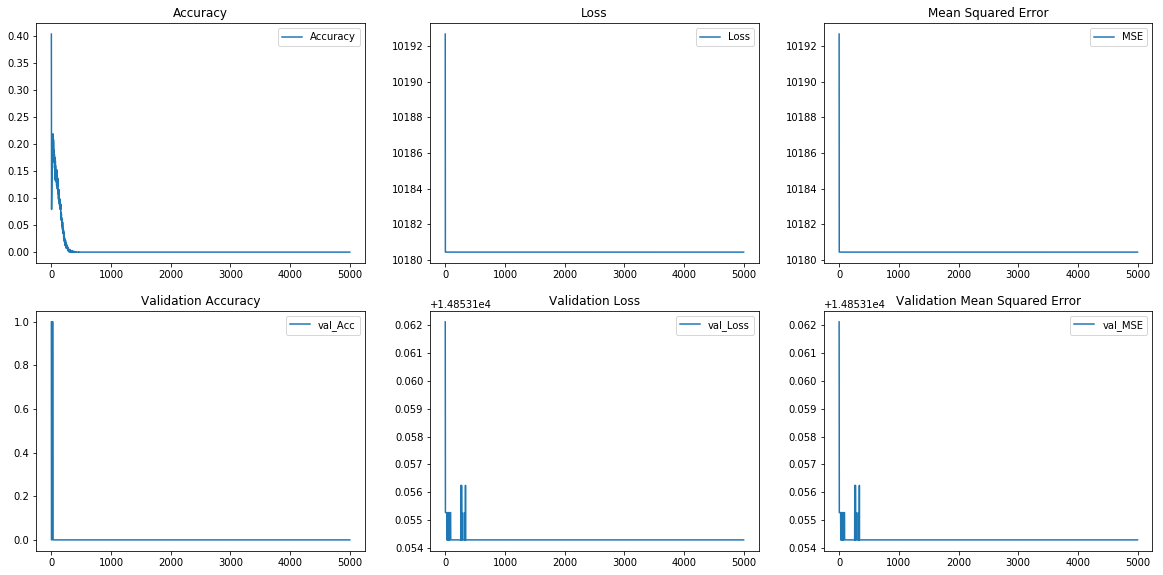

In [28]:
plt.figure(figsize=(20,15))
plt.subplot(331)
plt.plot(model_history.history['acc'] , label = 'Accuracy')
plt.legend(loc = 'upper right')
plt.title("Accuracy")

plt.subplot(332)
plt.plot(model_history.history['loss'] , label = 'Loss')
plt.legend(loc = 'upper right')
plt.title("Loss")

plt.subplot(333)
plt.plot(model_history.history['mean_squared_error'] , label = 'MSE')
plt.legend(loc = 'upper right')
plt.title("Mean Squared Error")

plt.subplot(334)
plt.plot(model_history.history['val_acc'] , label = 'val_Acc')
plt.legend(loc = 'upper right')
plt.title("Validation Accuracy")

plt.subplot(335)
plt.plot(model_history.history['val_loss'] , label = 'val_Loss')
plt.legend(loc = 'upper right')
plt.title("Validation Loss")

plt.subplot(336)
plt.plot(model_history.history['val_mean_squared_error'] , label = 'val_MSE')
plt.legend(loc = 'upper right')
plt.title("Validation Mean Squared Error")

plt.show()

In [29]:
testPredict = model.predict(x_test , verbose = 1)

1/1 [==============================] - 5s 5s/step


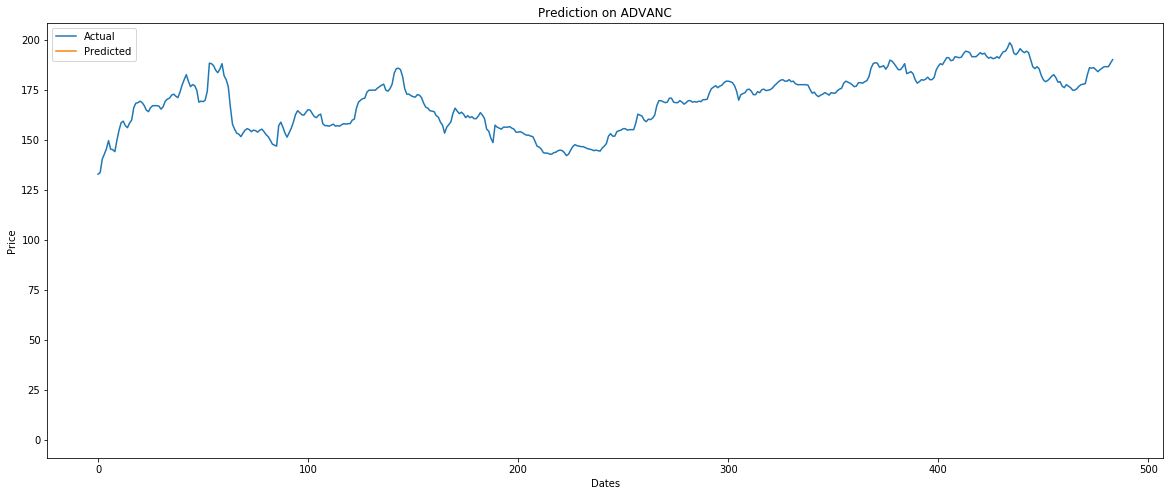

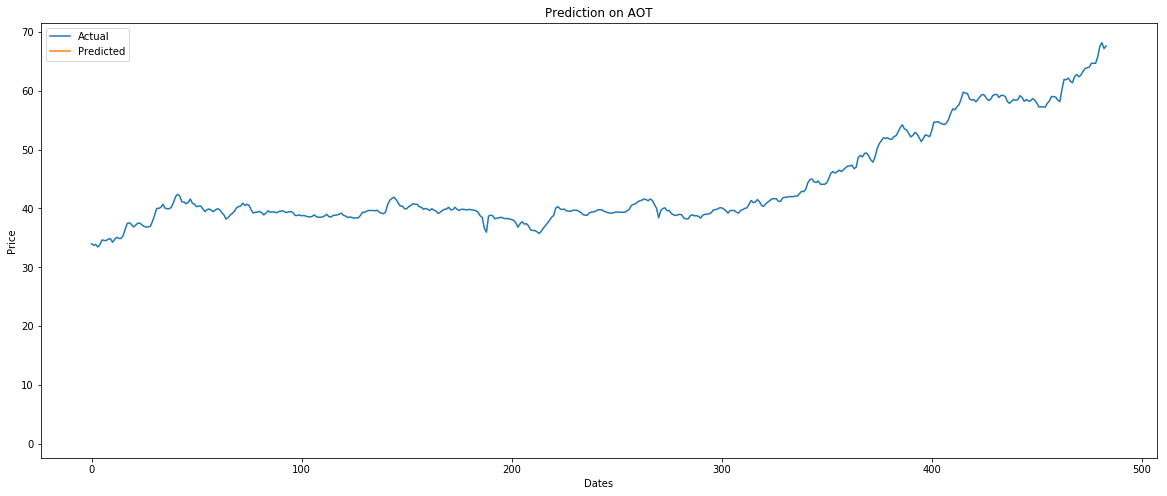

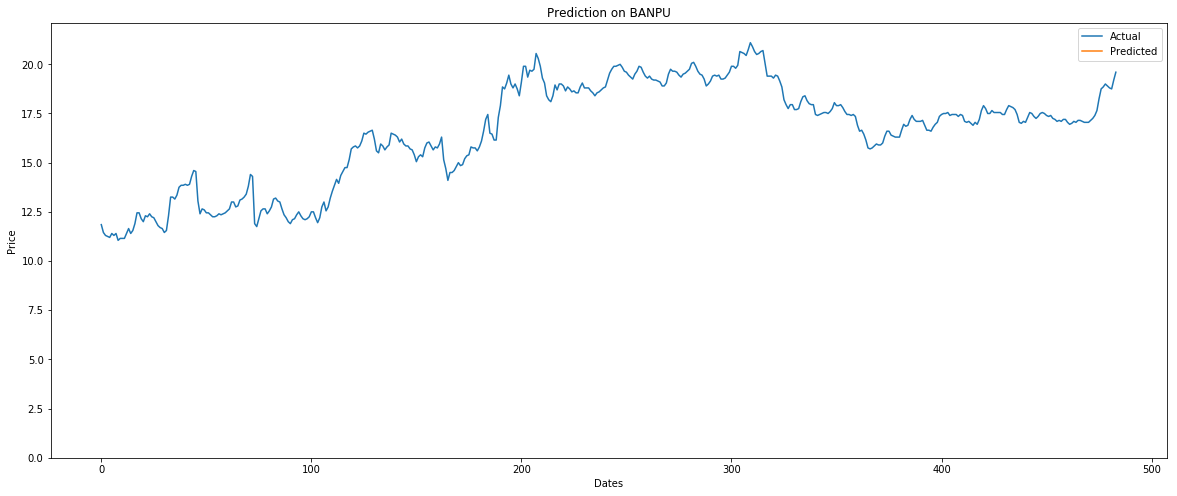

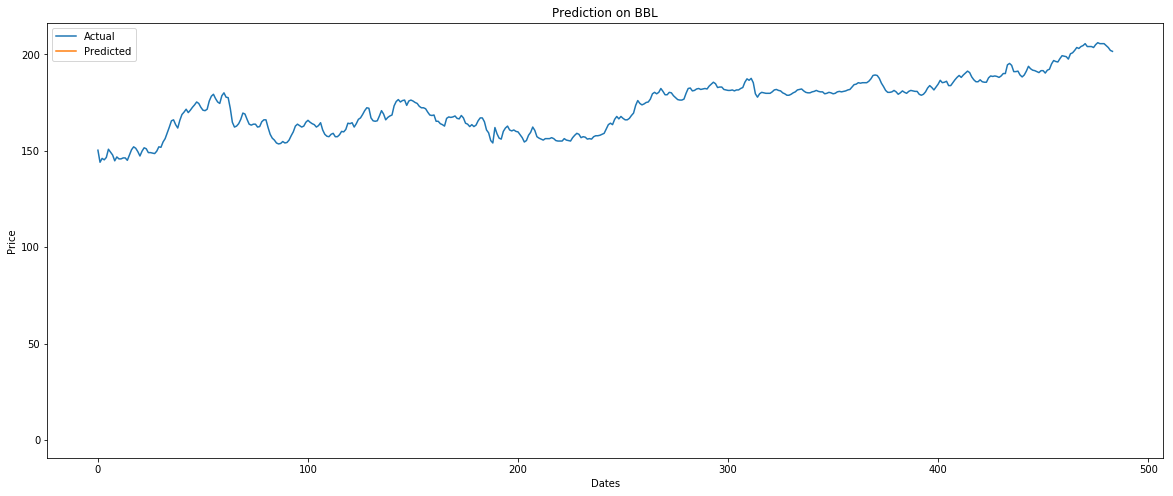

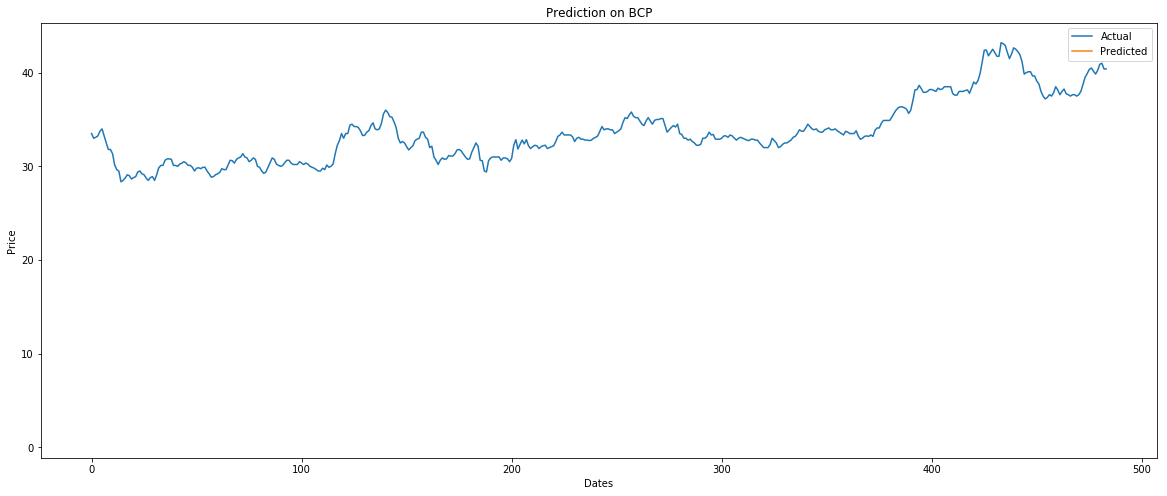

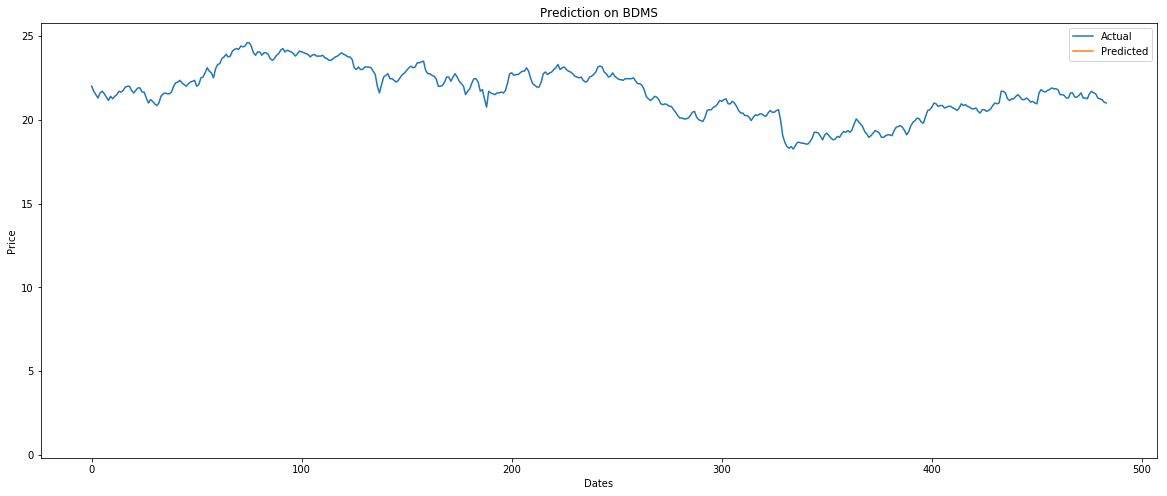

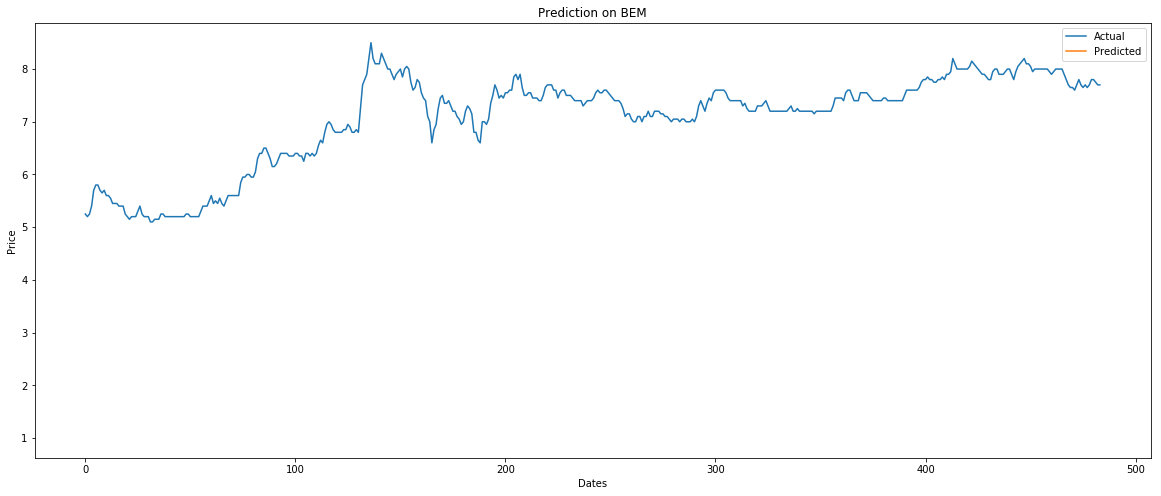

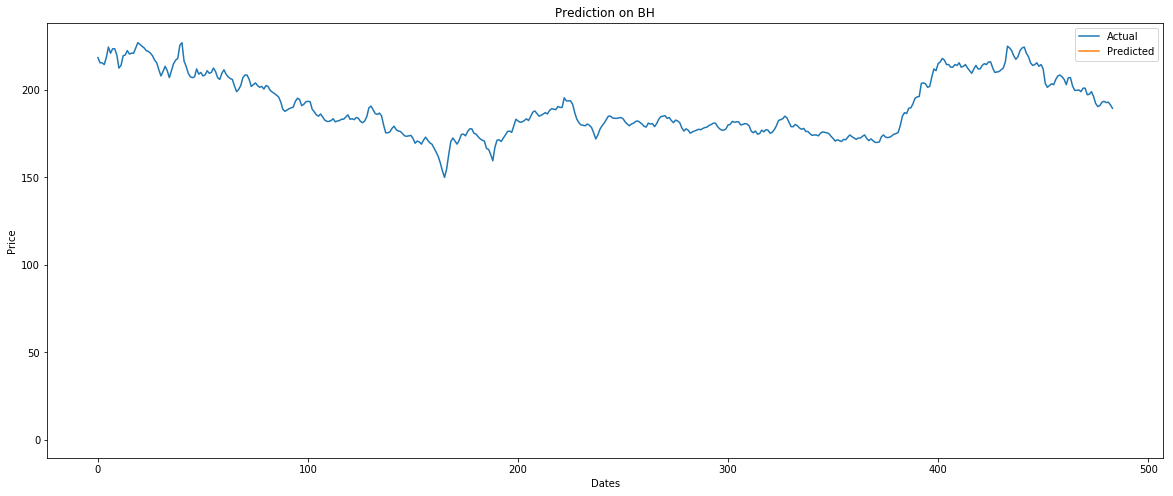

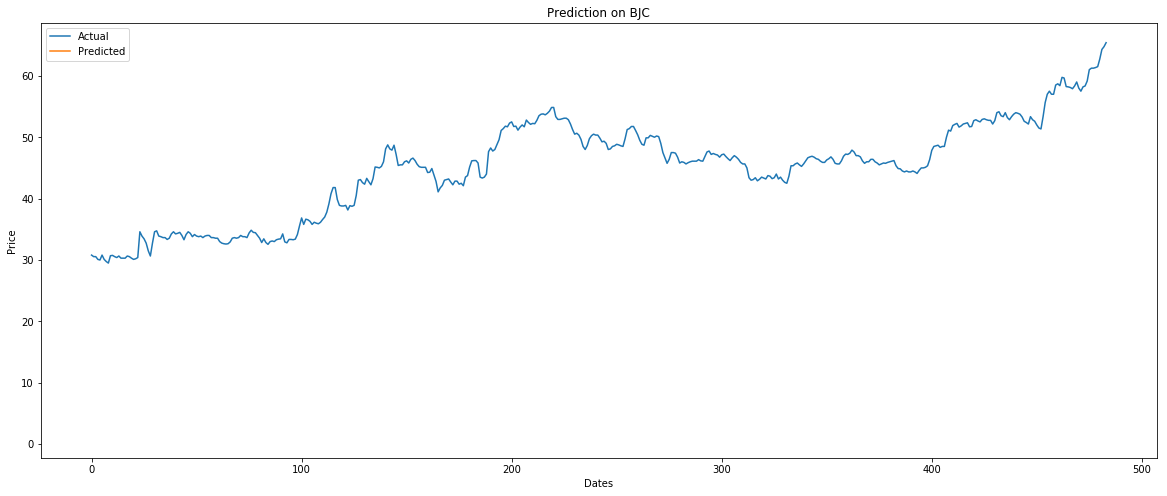

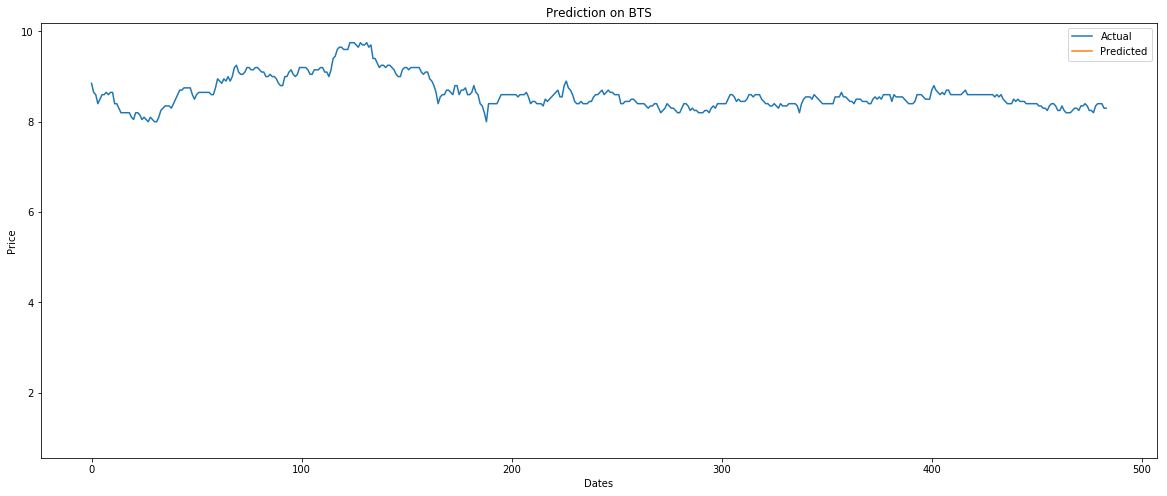

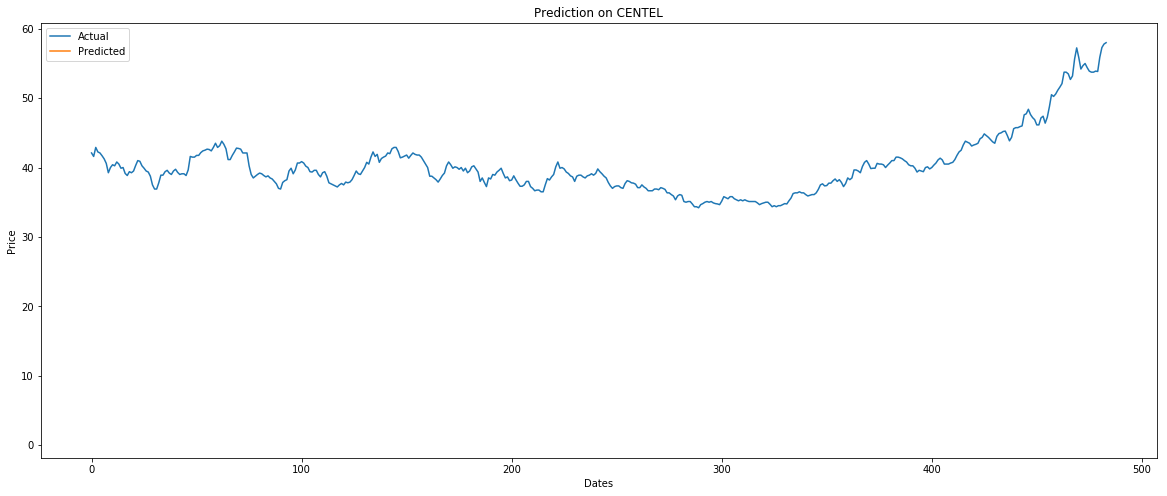

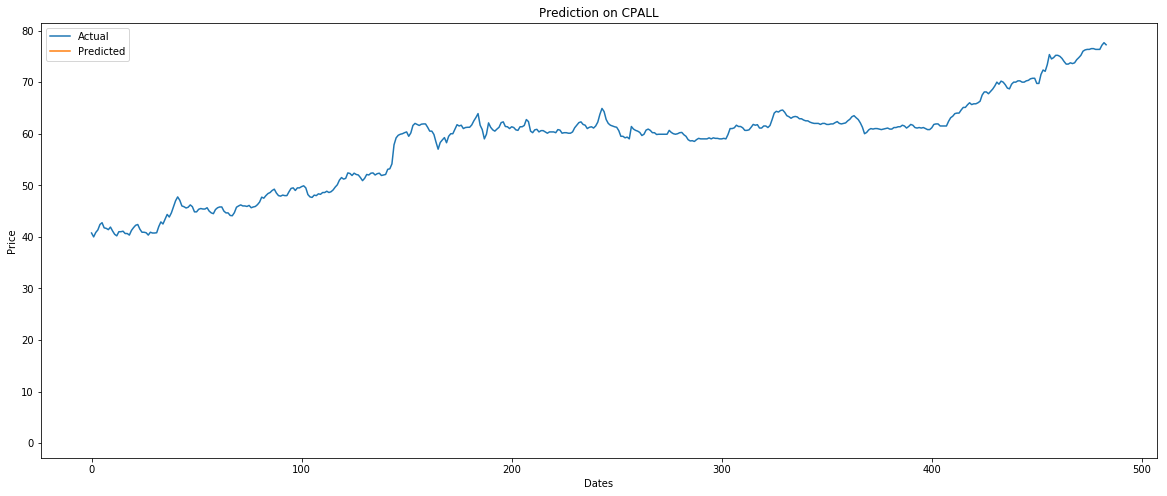

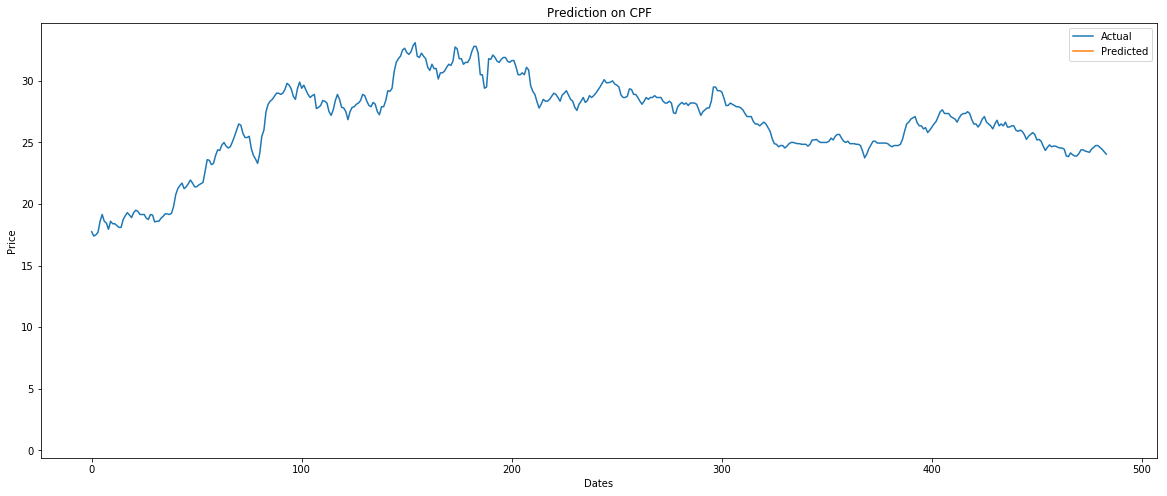

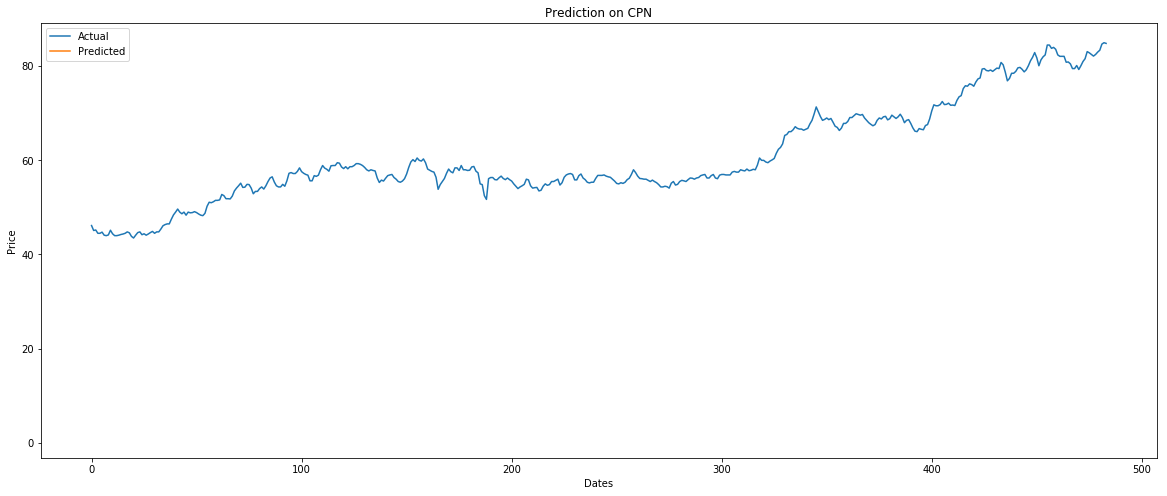

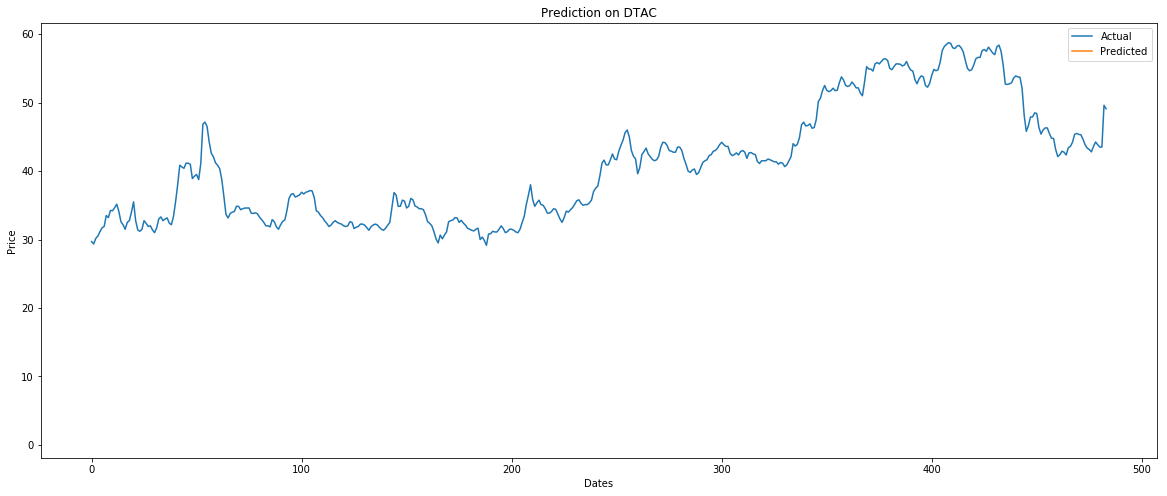

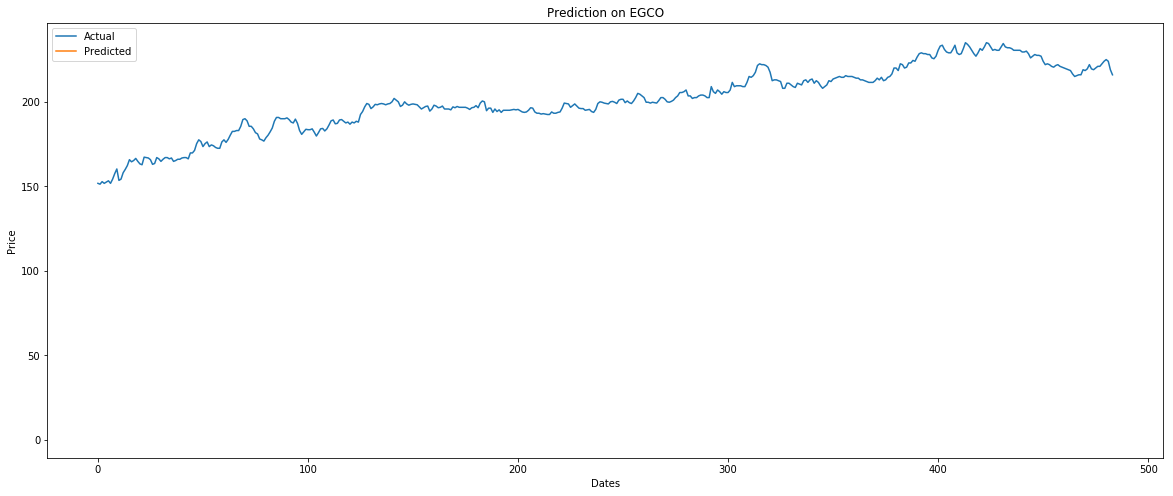

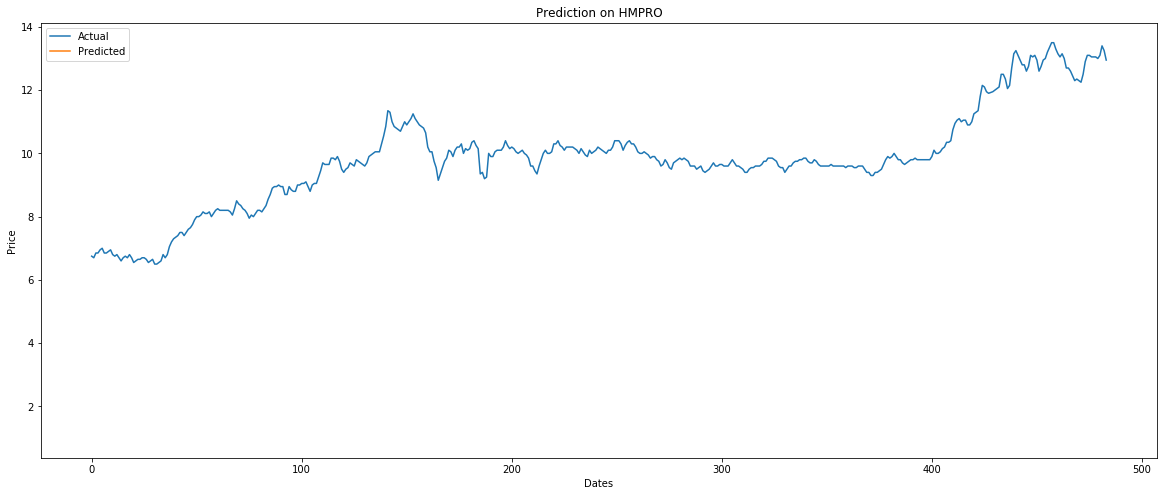

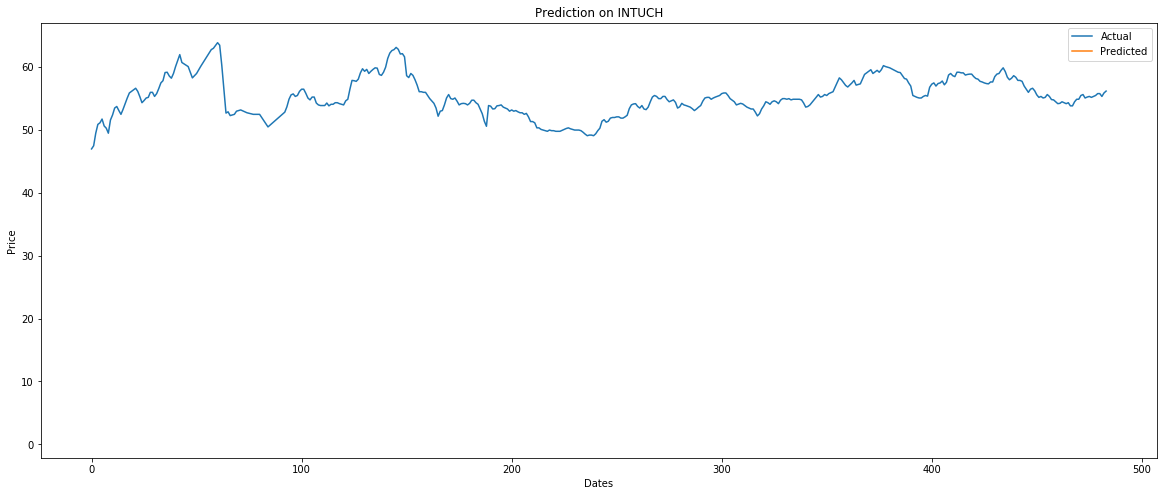

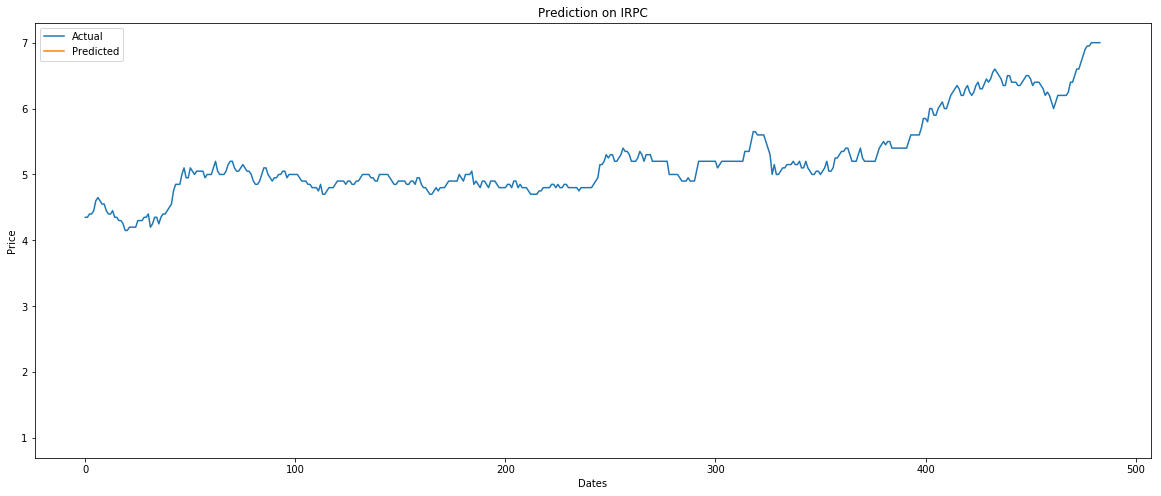

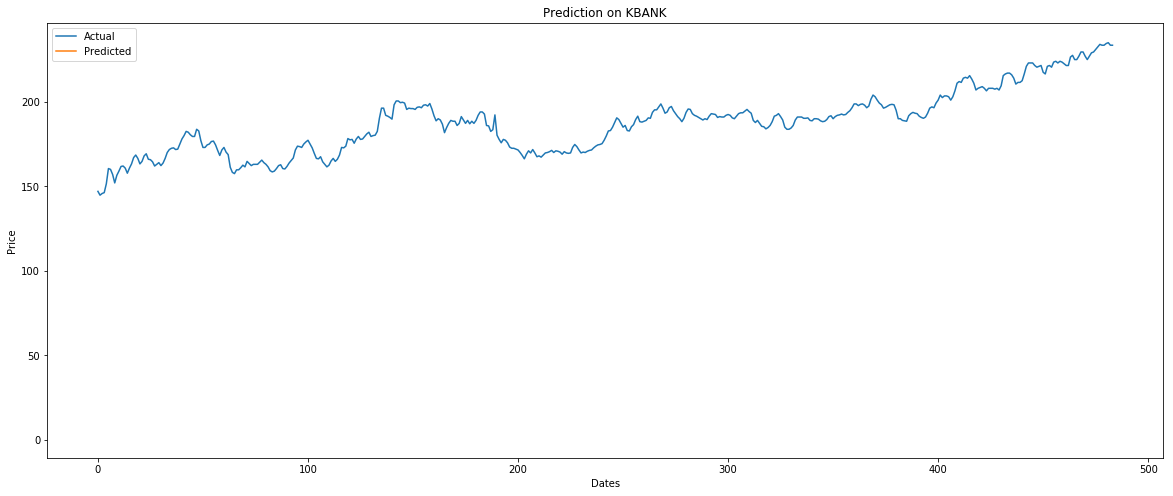

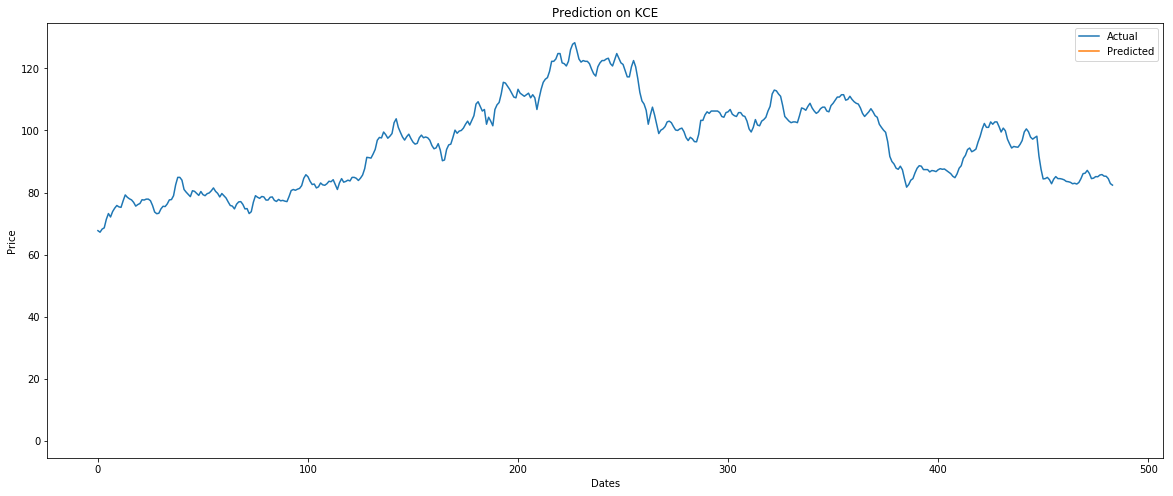

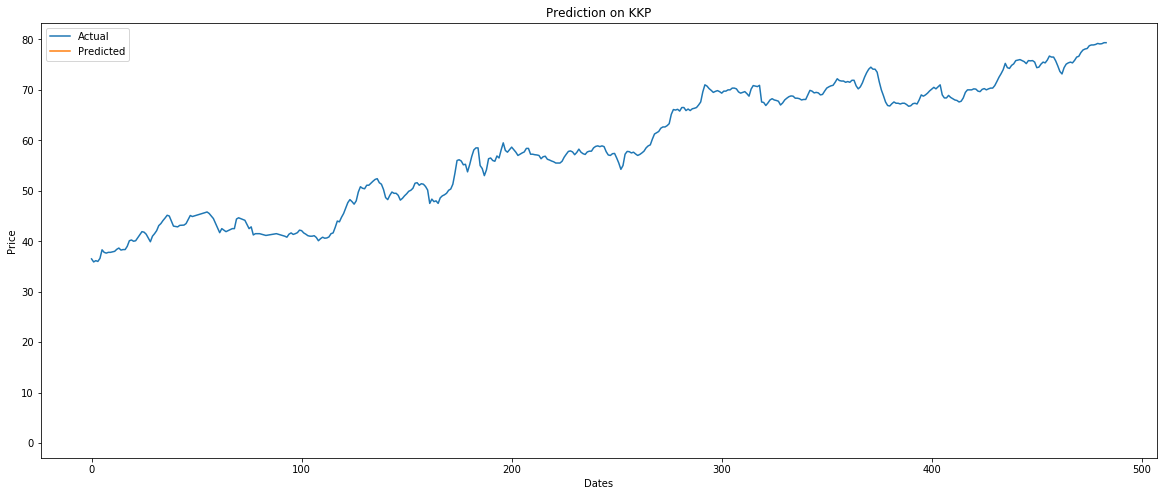

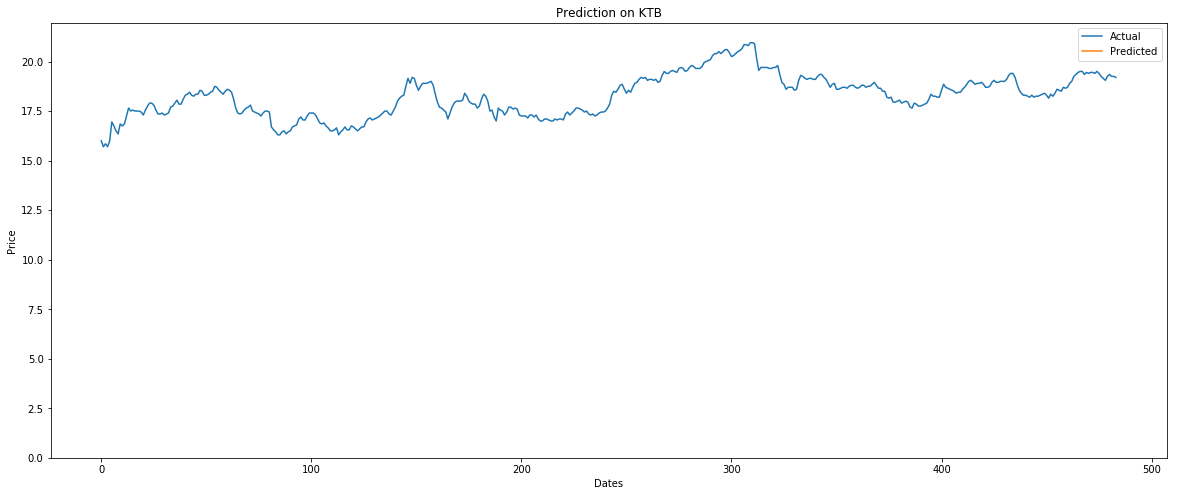

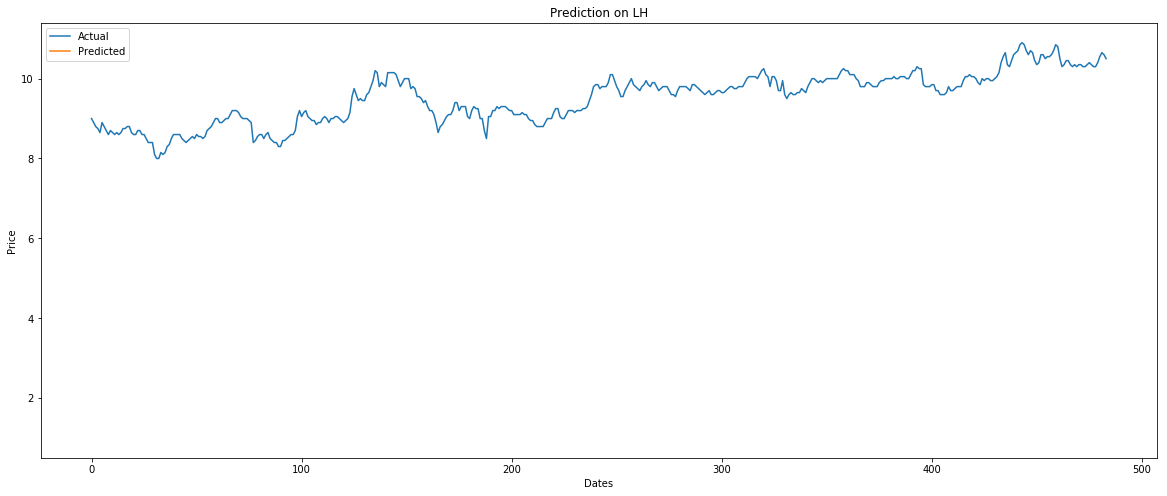

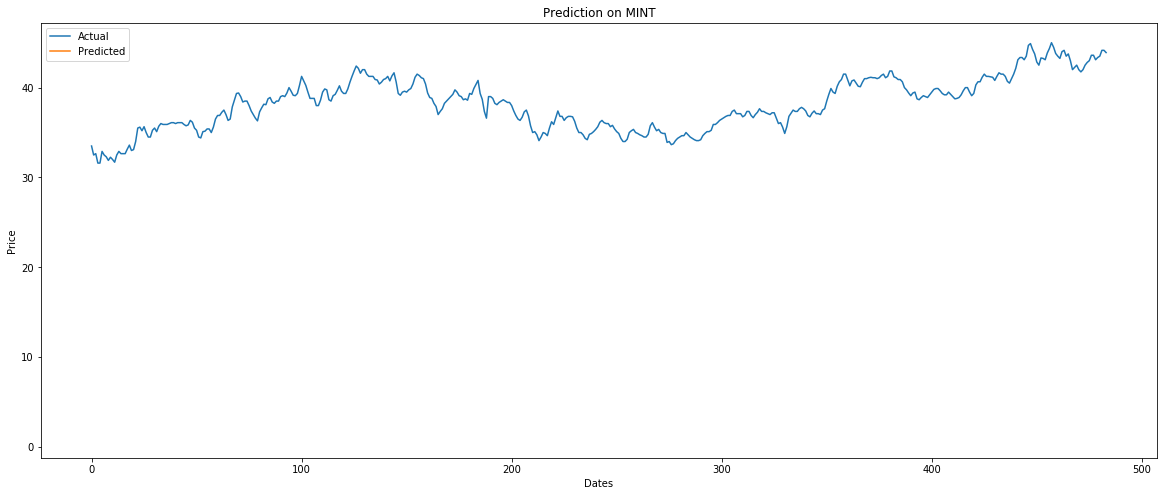

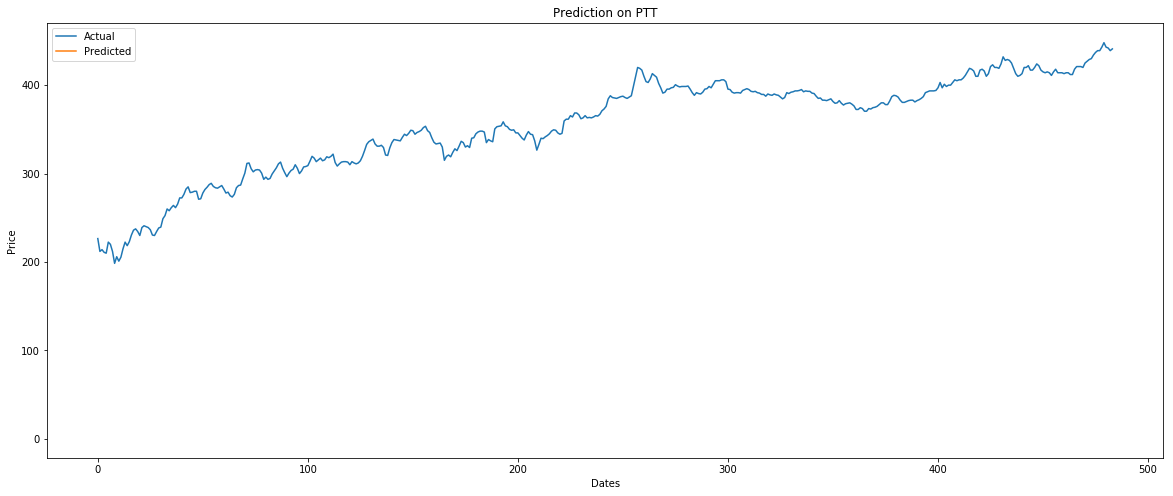

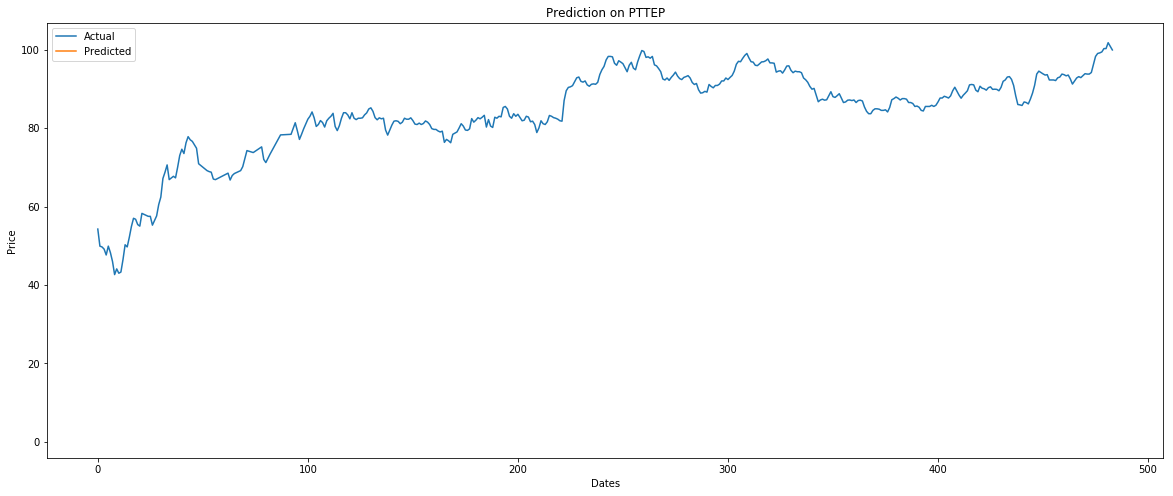

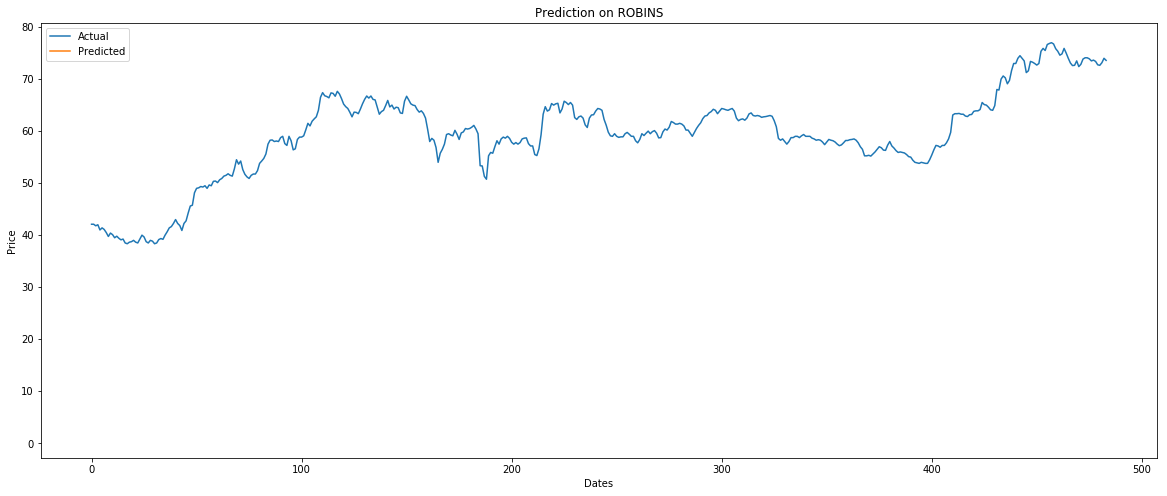

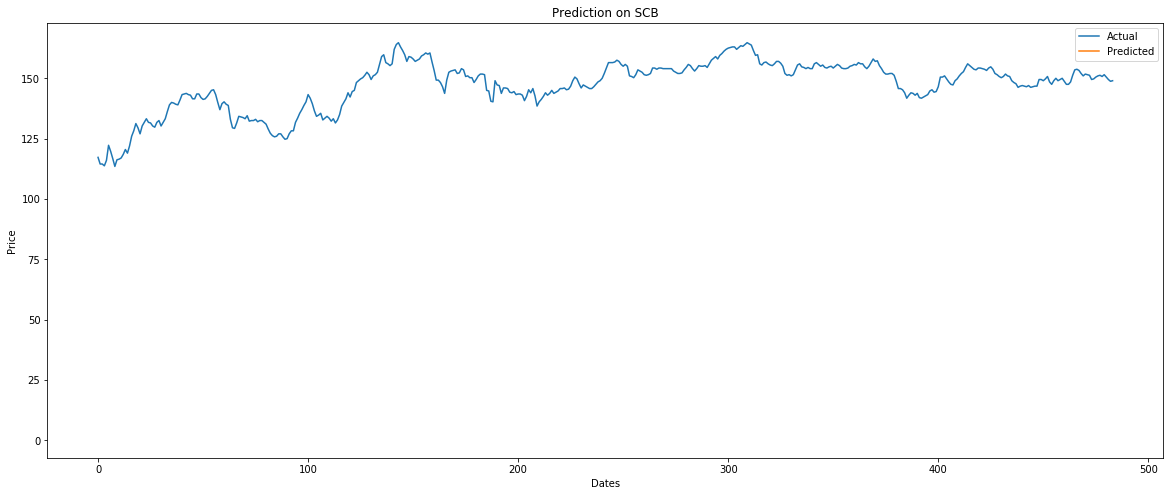

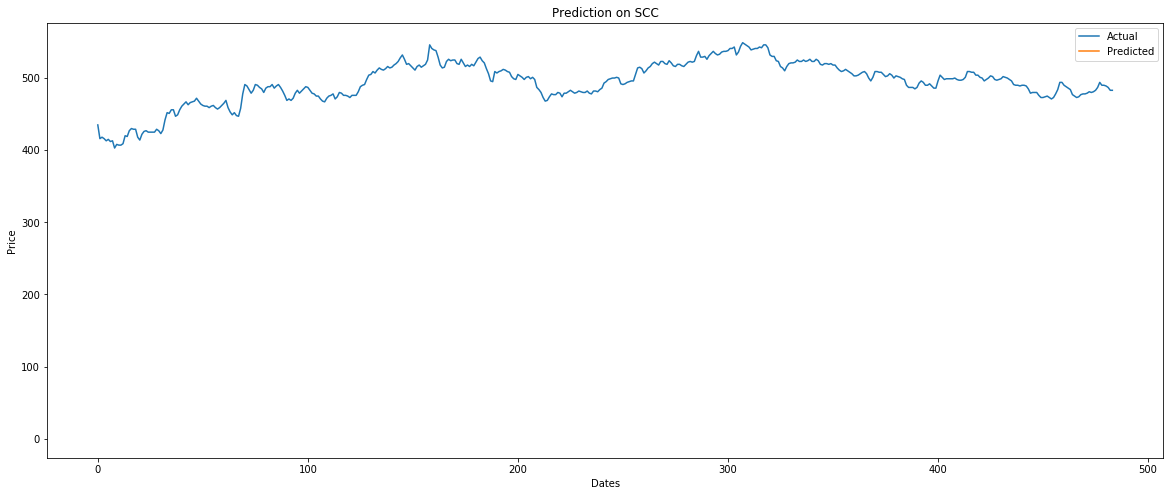

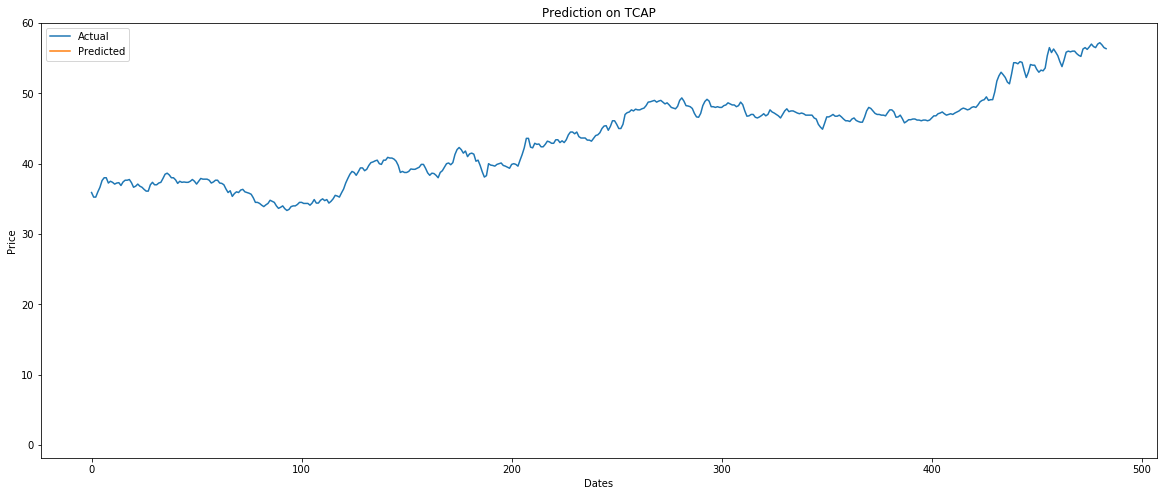

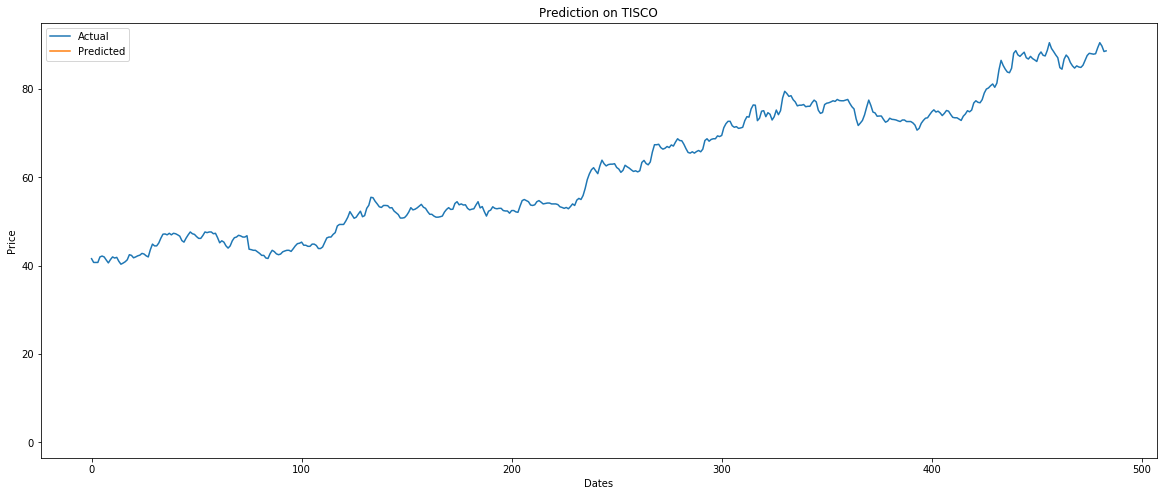

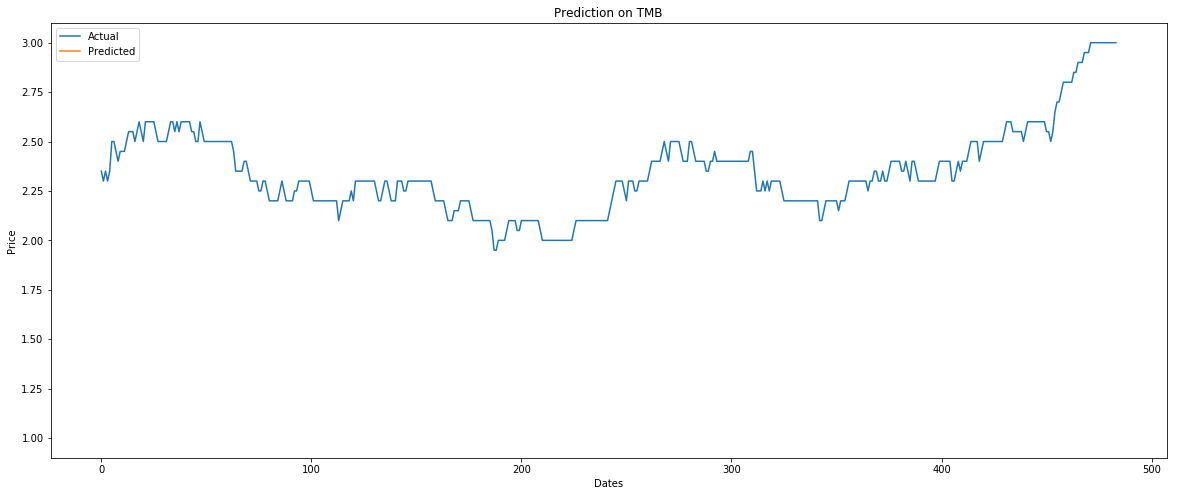

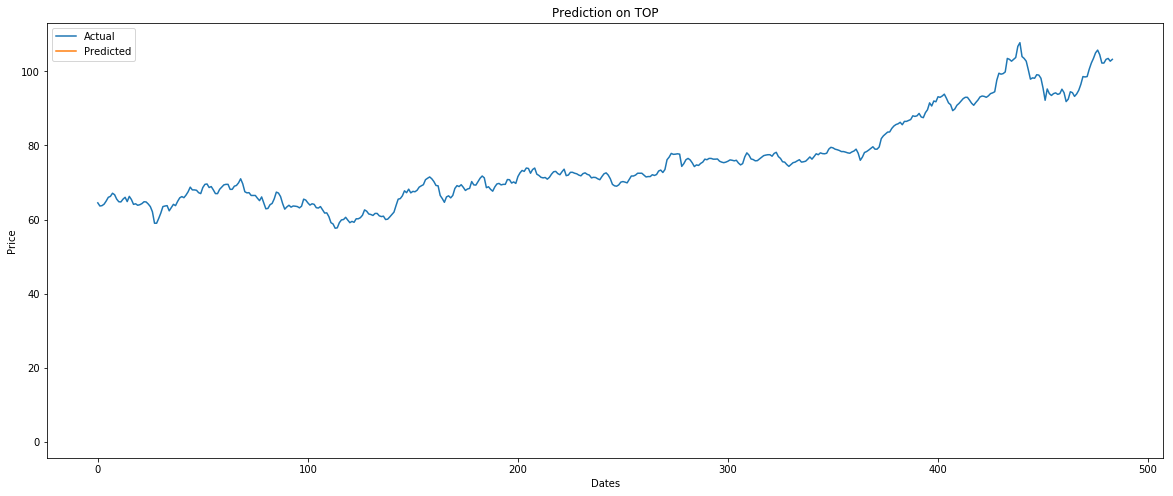

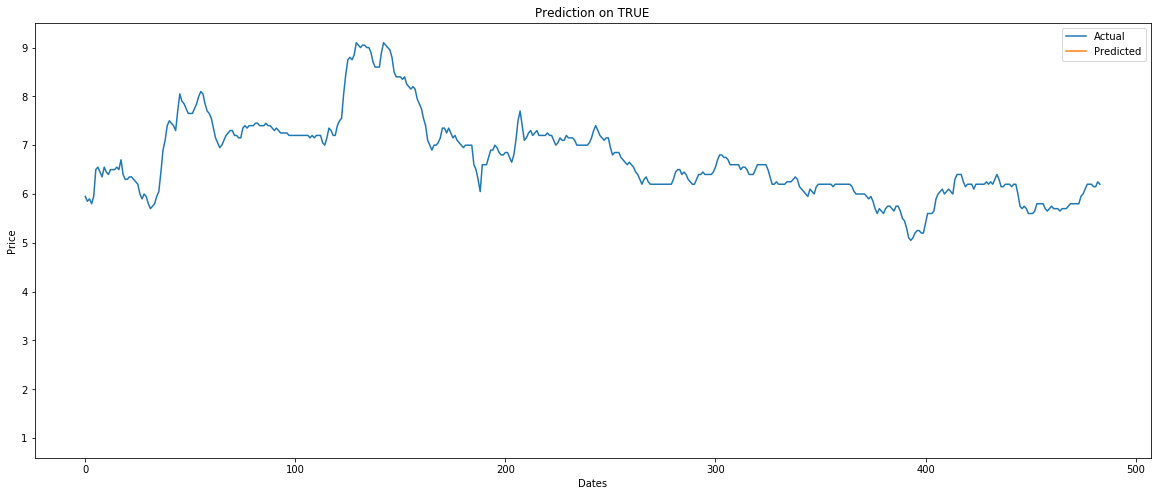

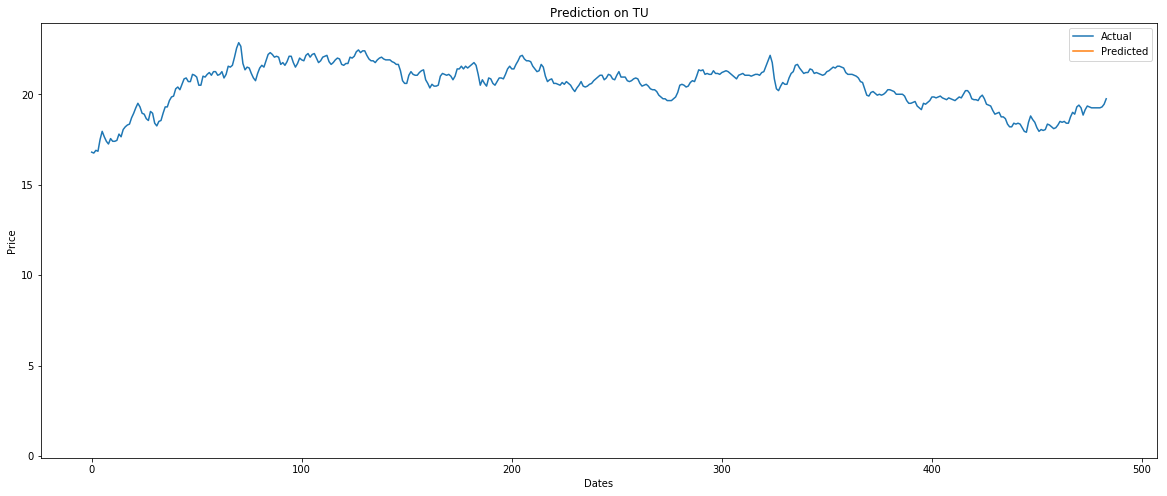

In [30]:
for index, value in enumerate(SET50):
    plt.figure(figsize=(20, 8))
    plt.plot(y_test[:,index])
    plt.plot(testPredict[:,index])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title('Prediction on ' + value)
    plt.legend(['Actual','Predicted'])
    plt.show()

In [12]:
# model = load_model('LSTM_512_128_10000.h5')

In [13]:
x_test[0].shape

(36, 30)

In [31]:
predicts = []
test_data = x_test.copy()
for (index, element) in enumerate(y_test):
    predict = model.predict(test_data, verbose = 0)
    predicts.append(predict[0])
    test_data = findNewXTest(test_data, predict[0])

In [35]:
def plot_graph(array1, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


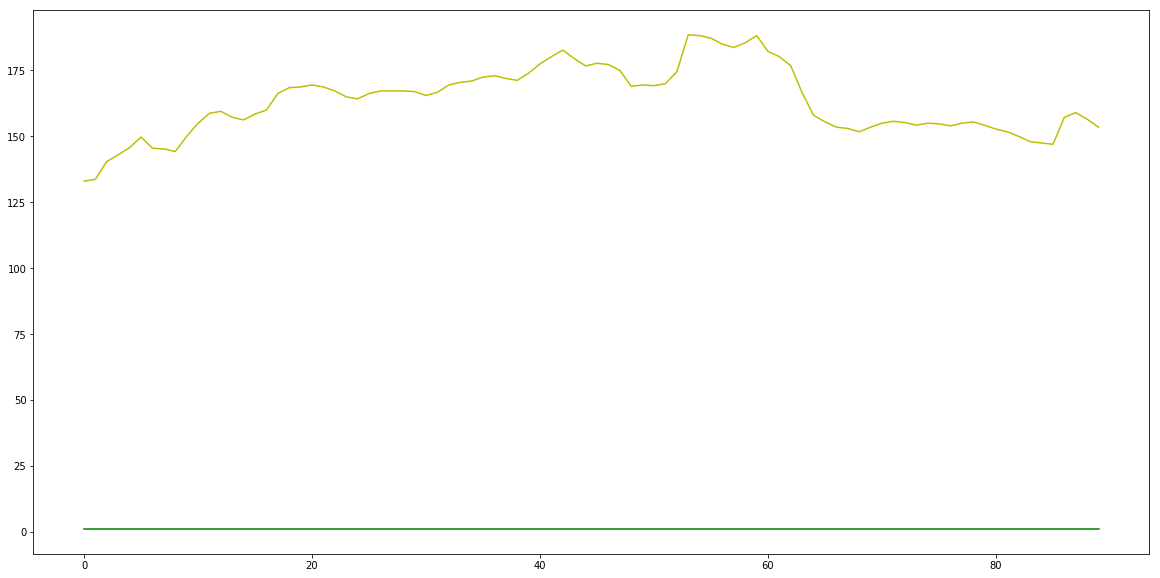

AOT


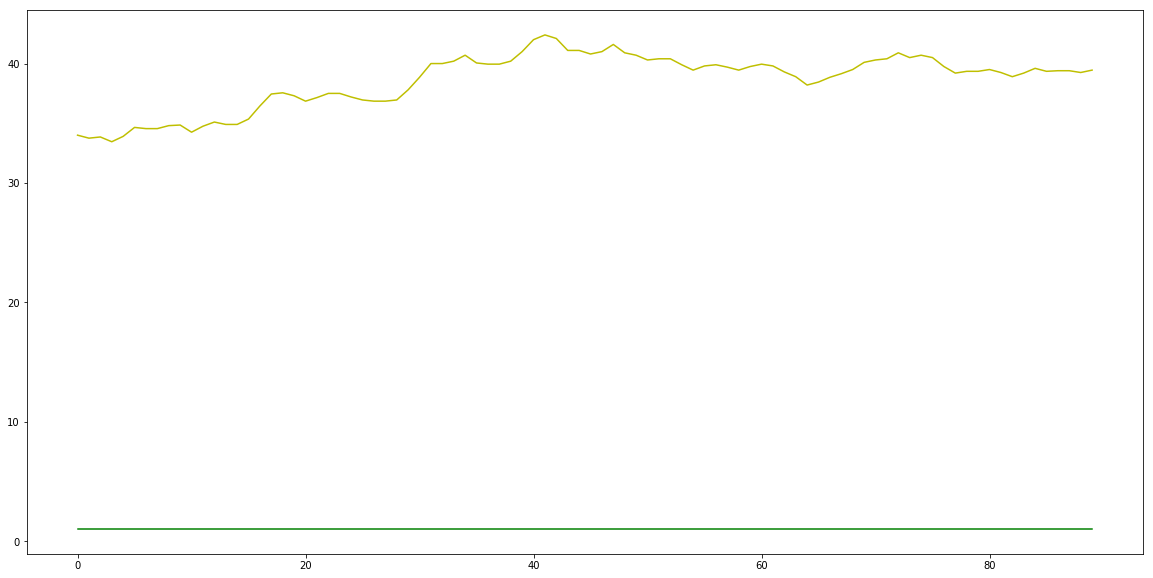

BANPU


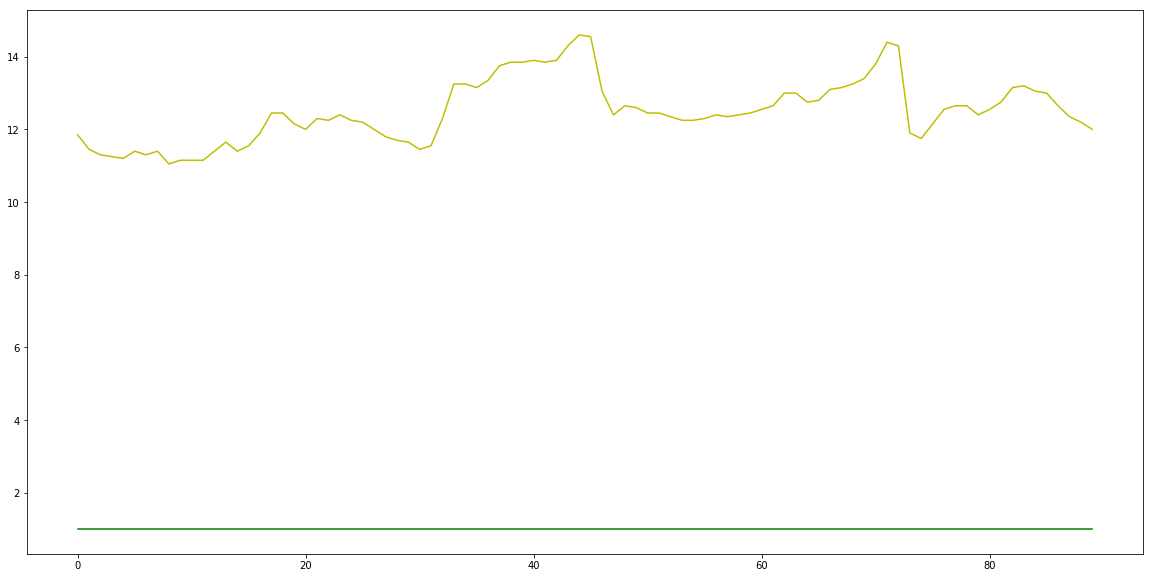

BBL


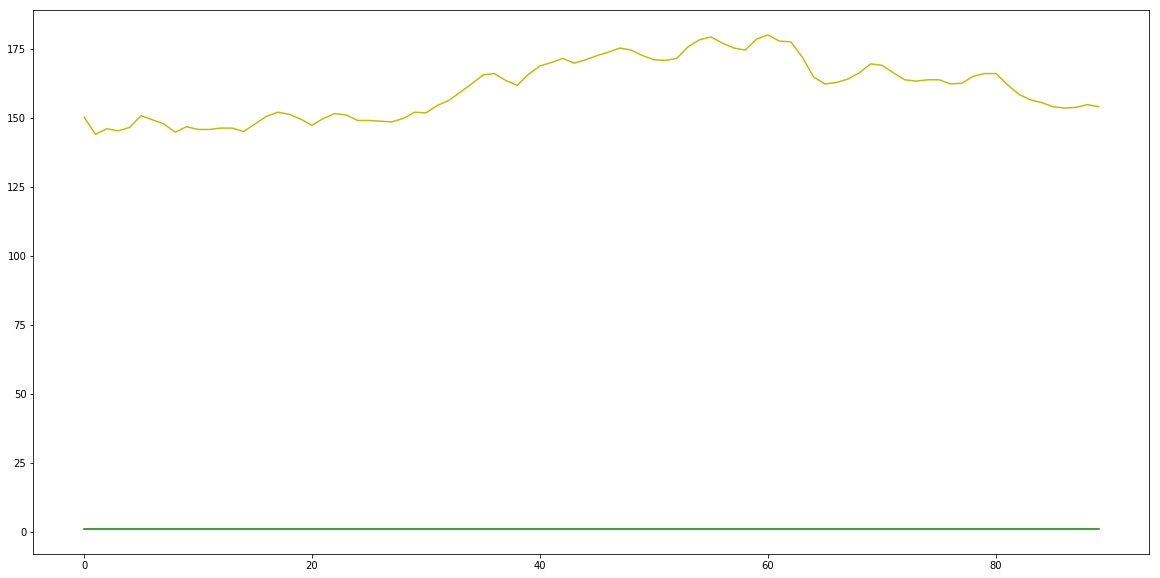

BCP


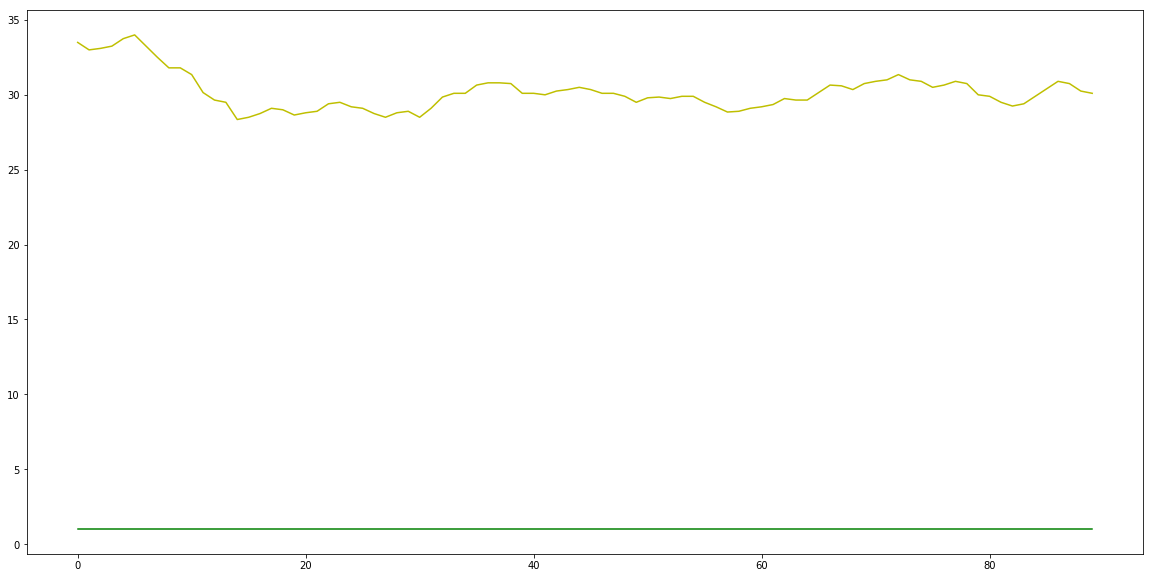

BDMS


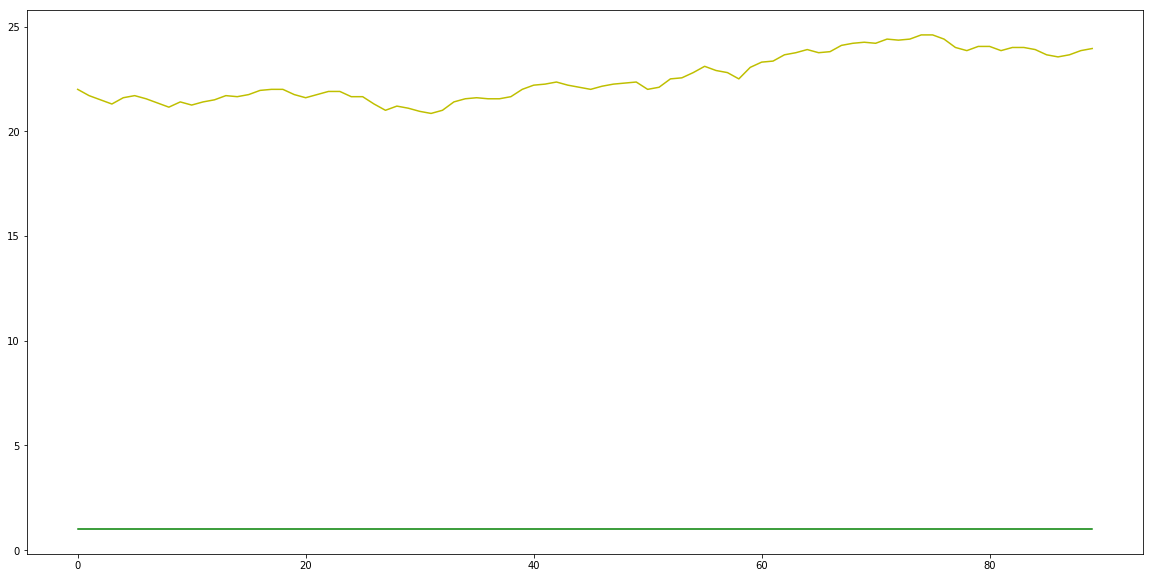

BEM


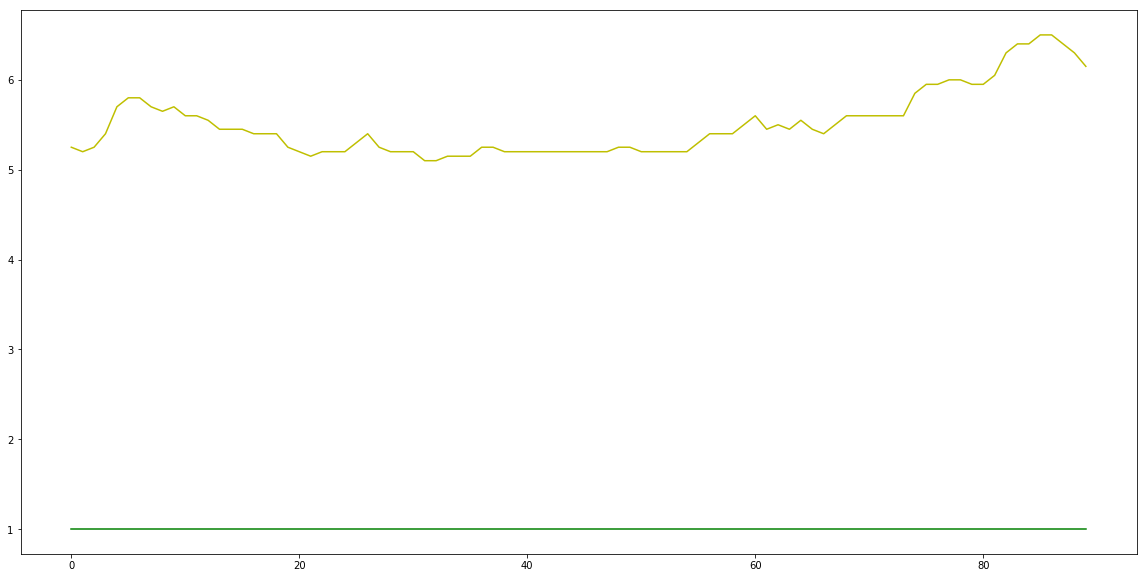

BH


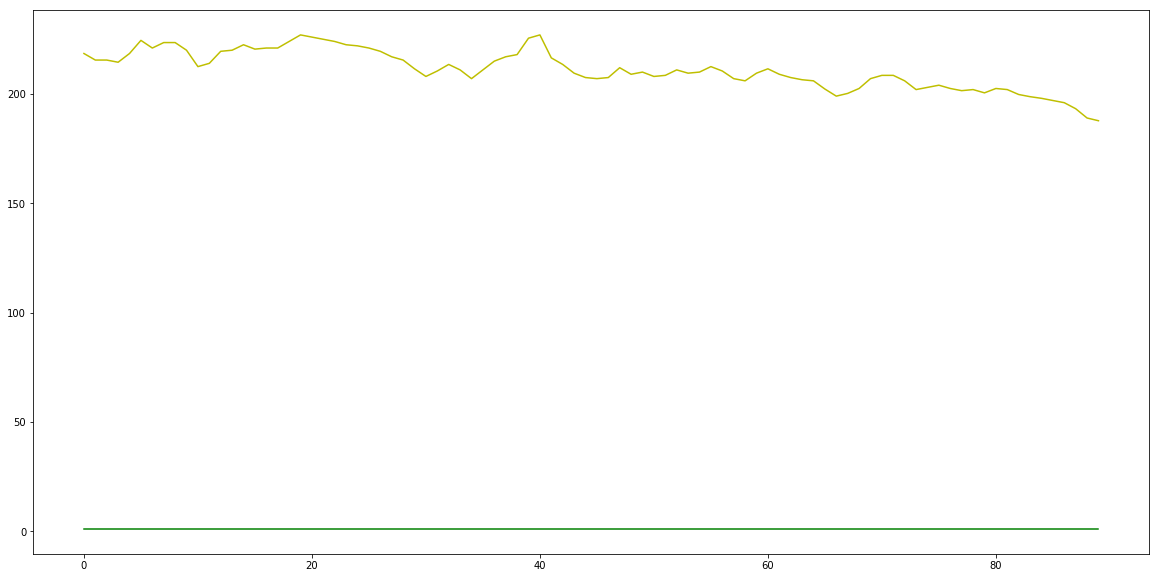

BJC


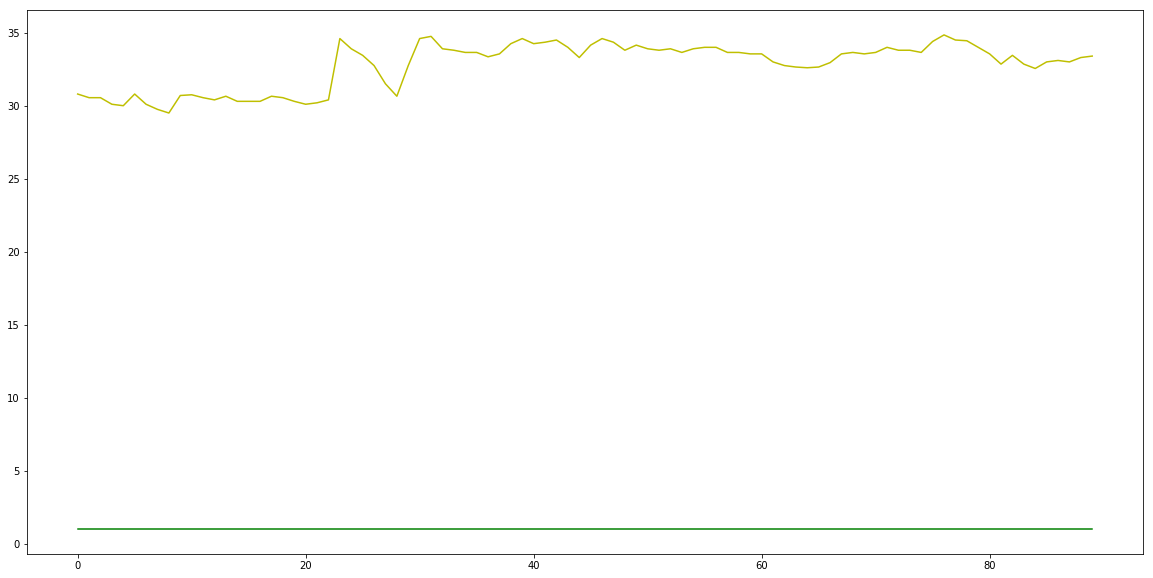

BTS


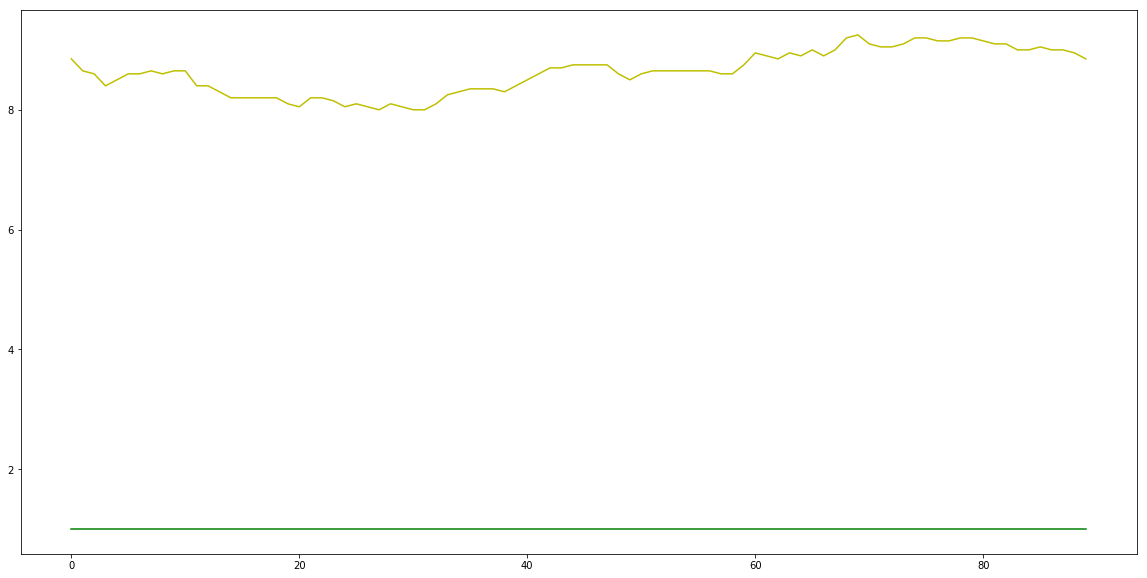

CENTEL


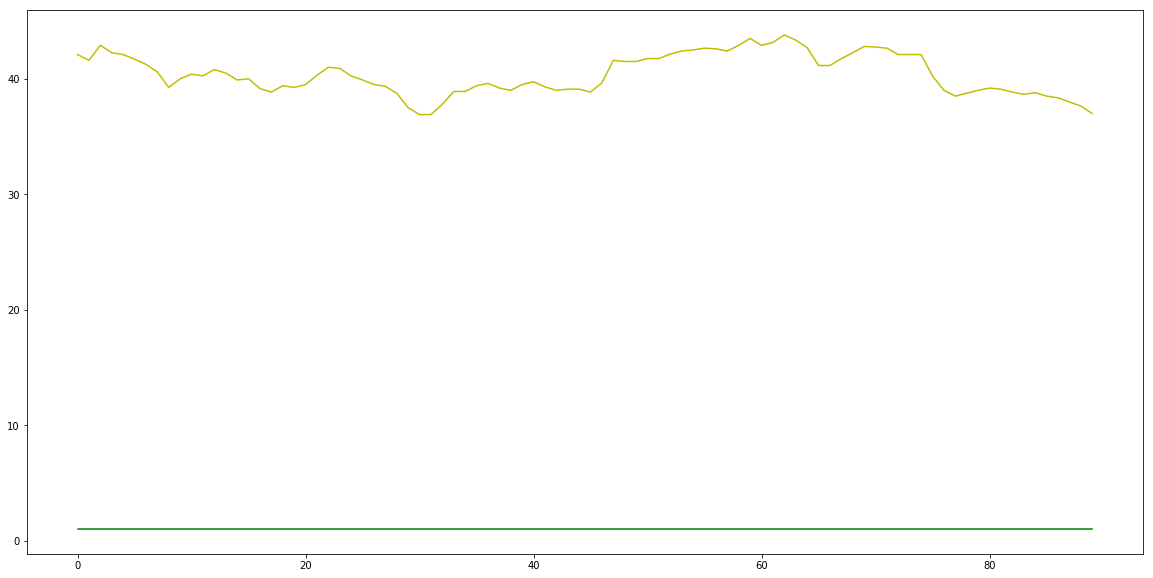

CPALL


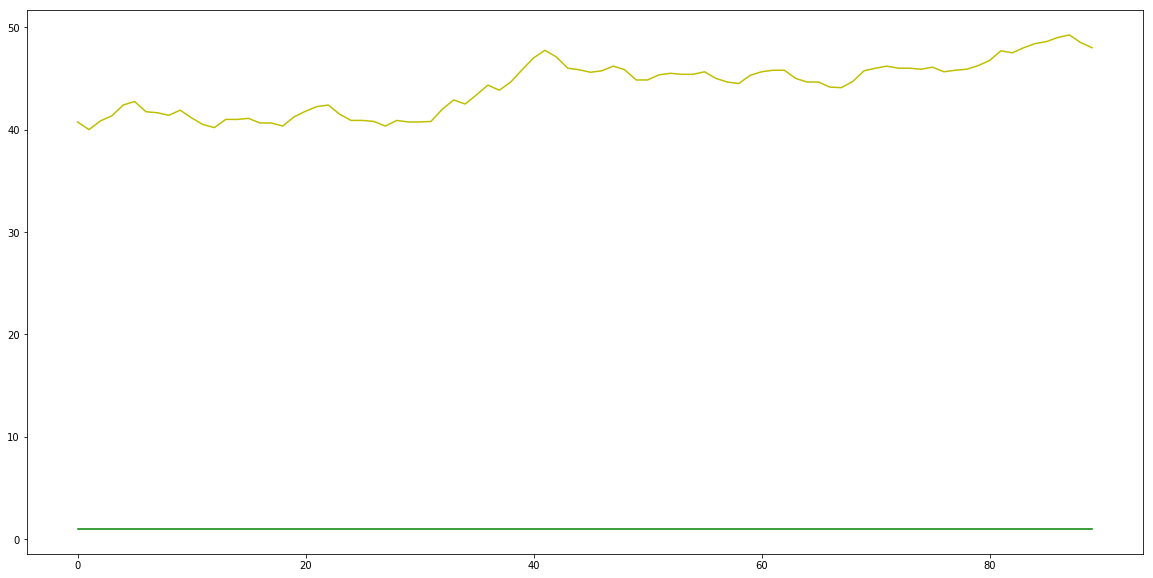

CPF


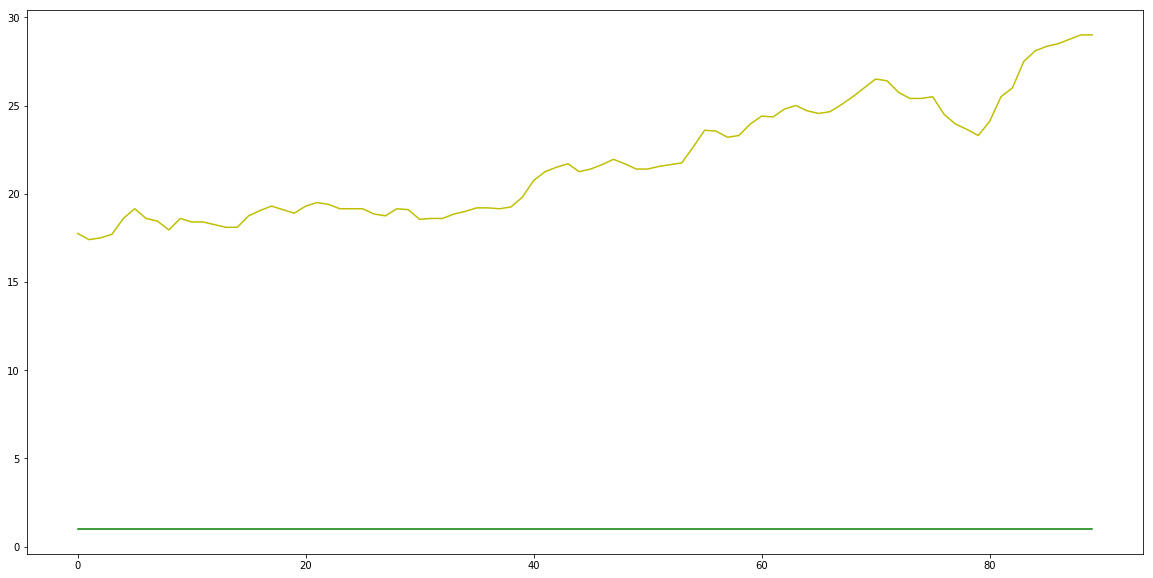

CPN


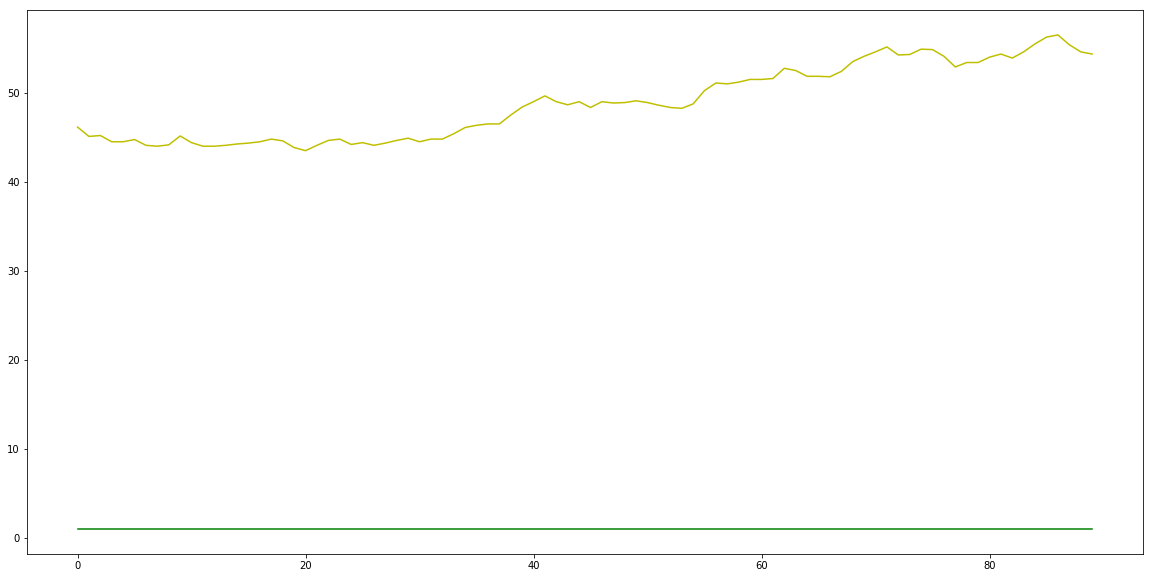

DTAC


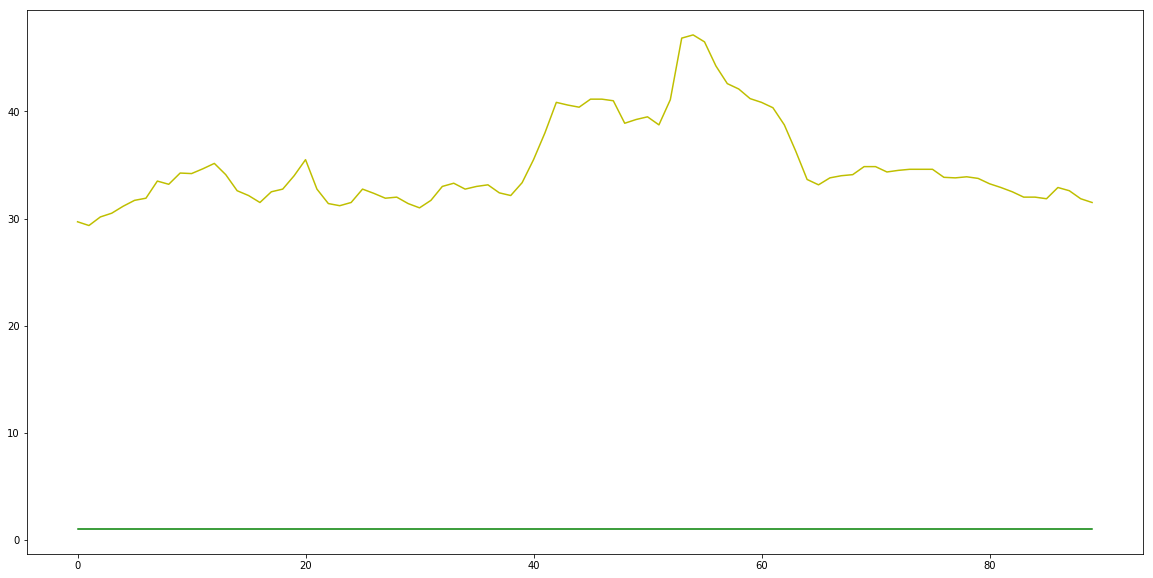

EGCO


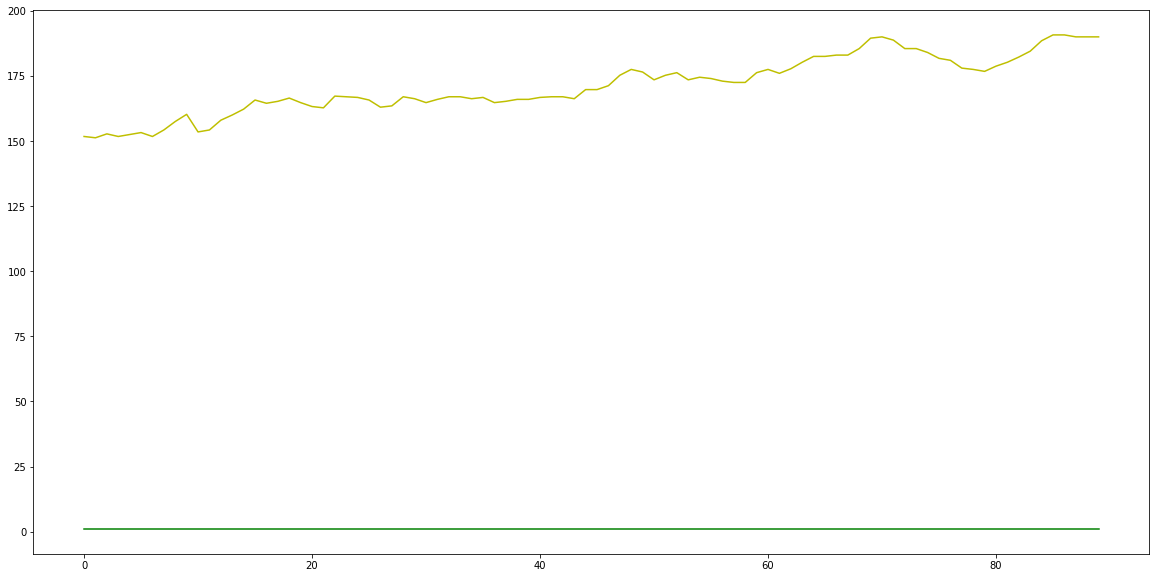

HMPRO


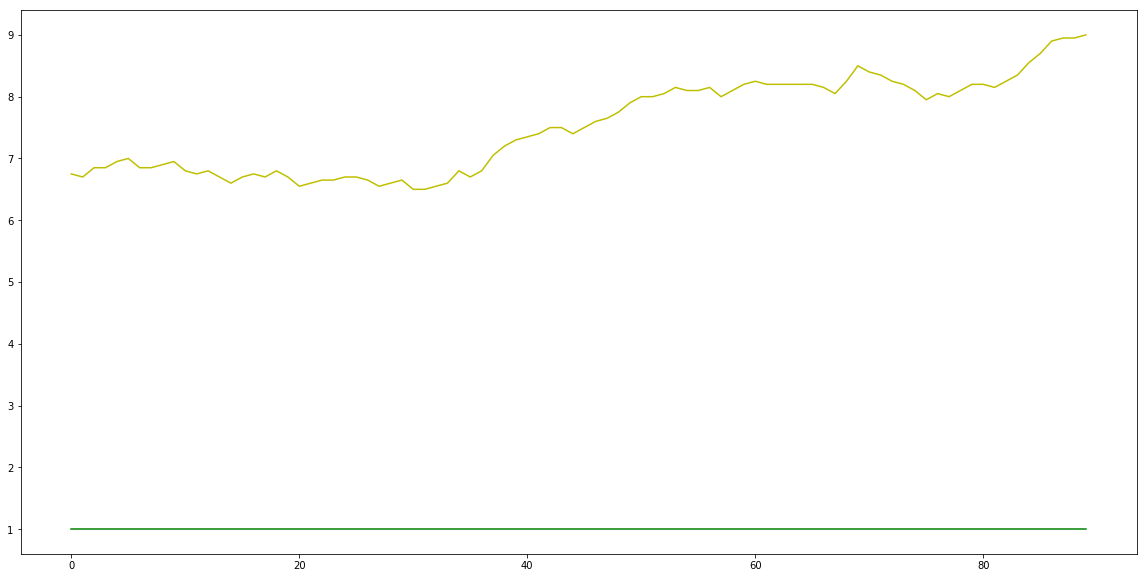

INTUCH


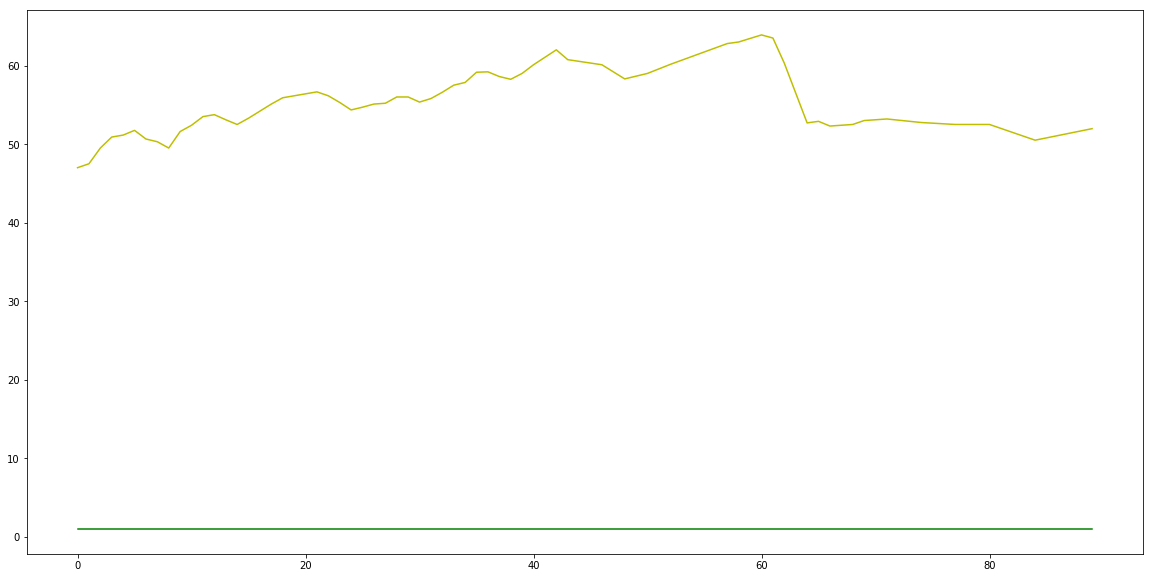

IRPC


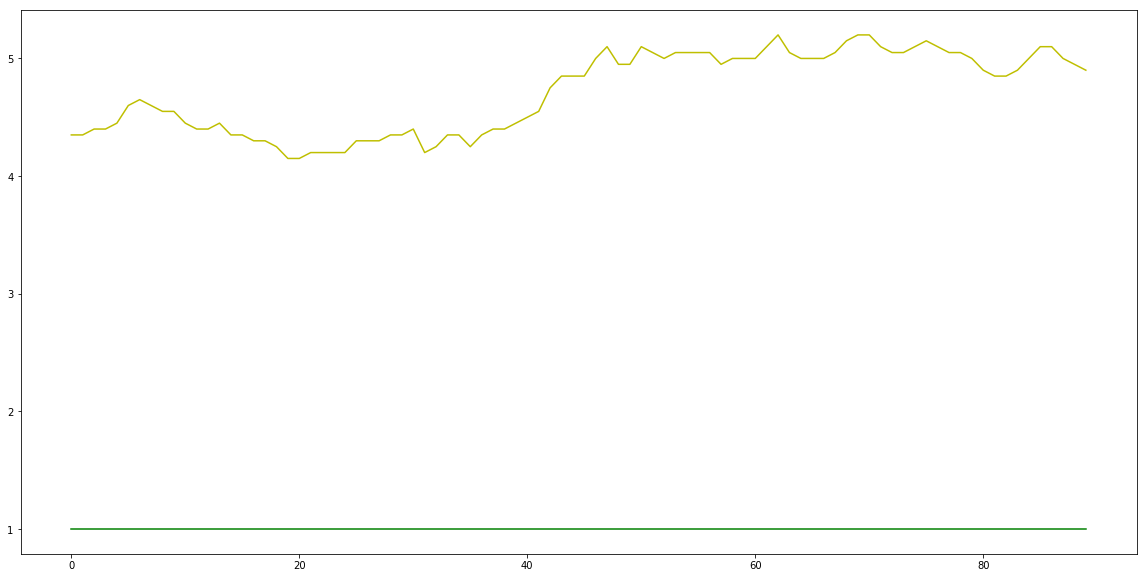

KBANK


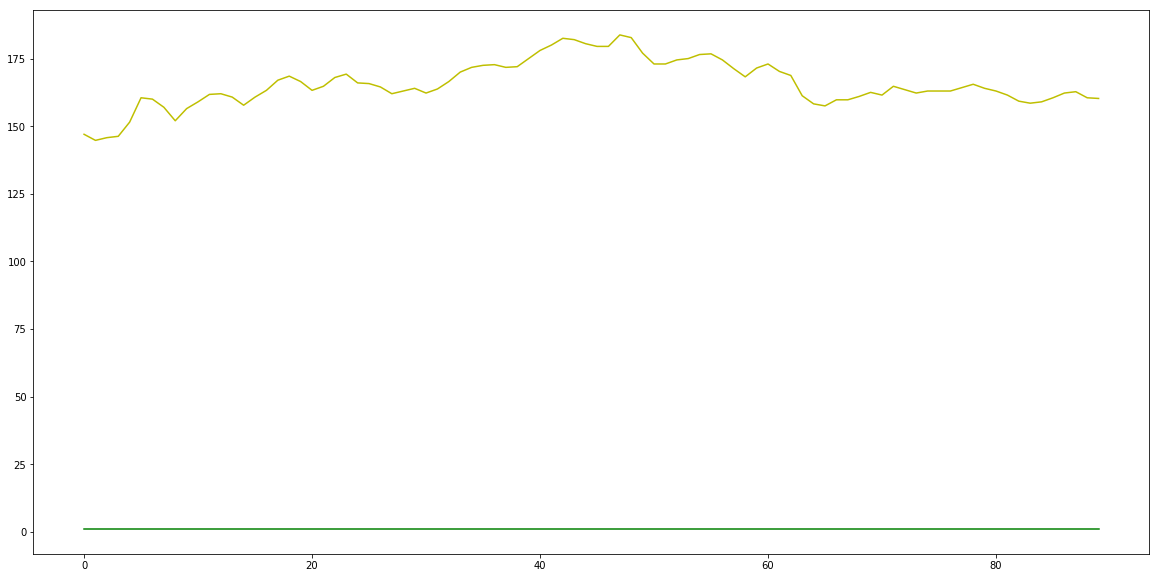

KCE


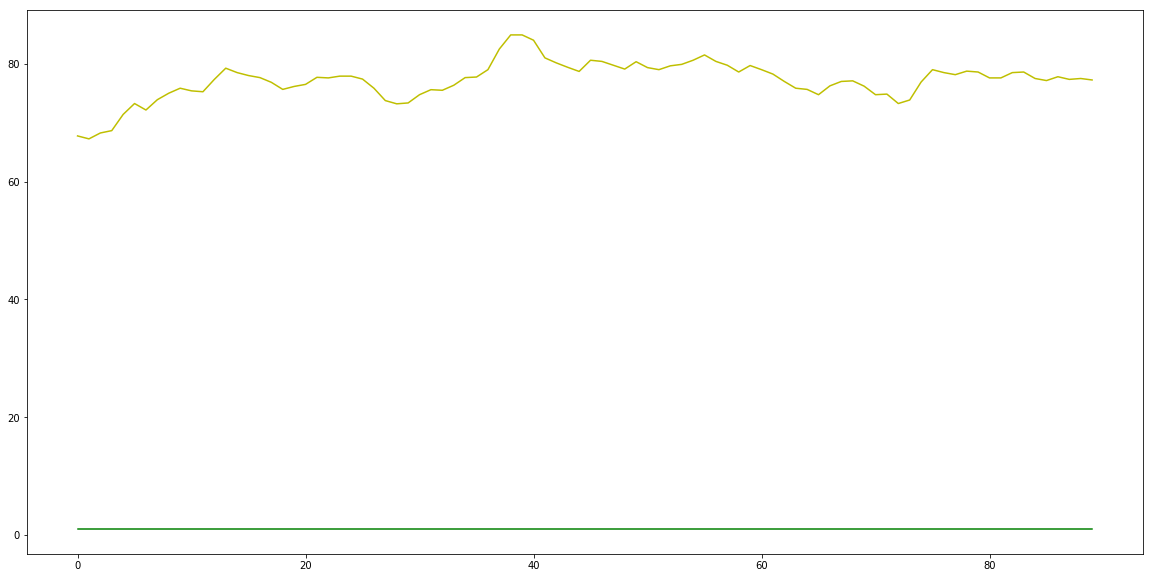

KKP


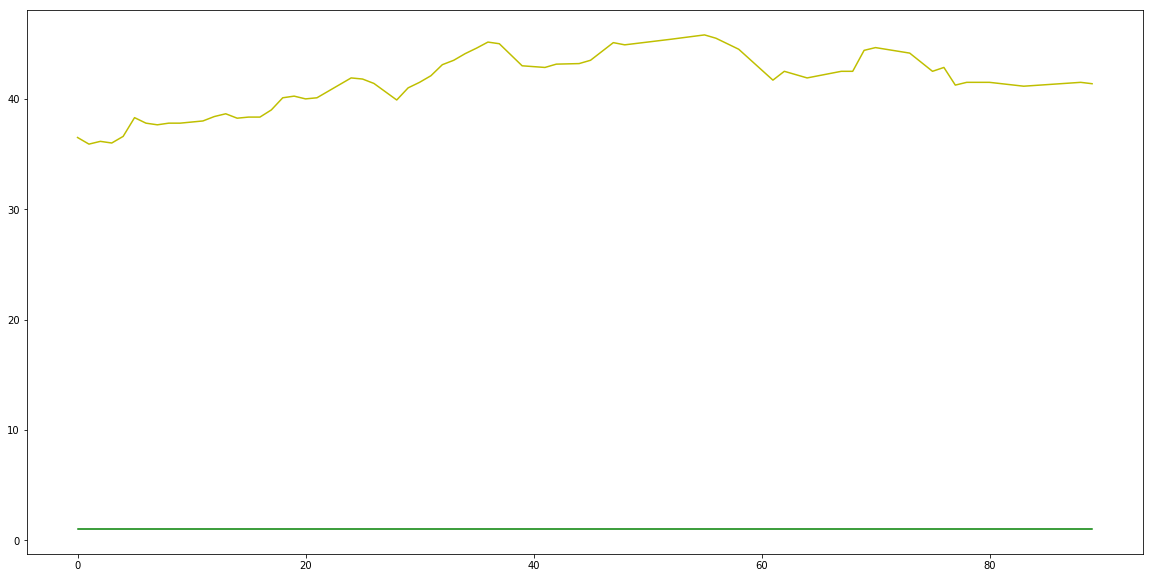

KTB


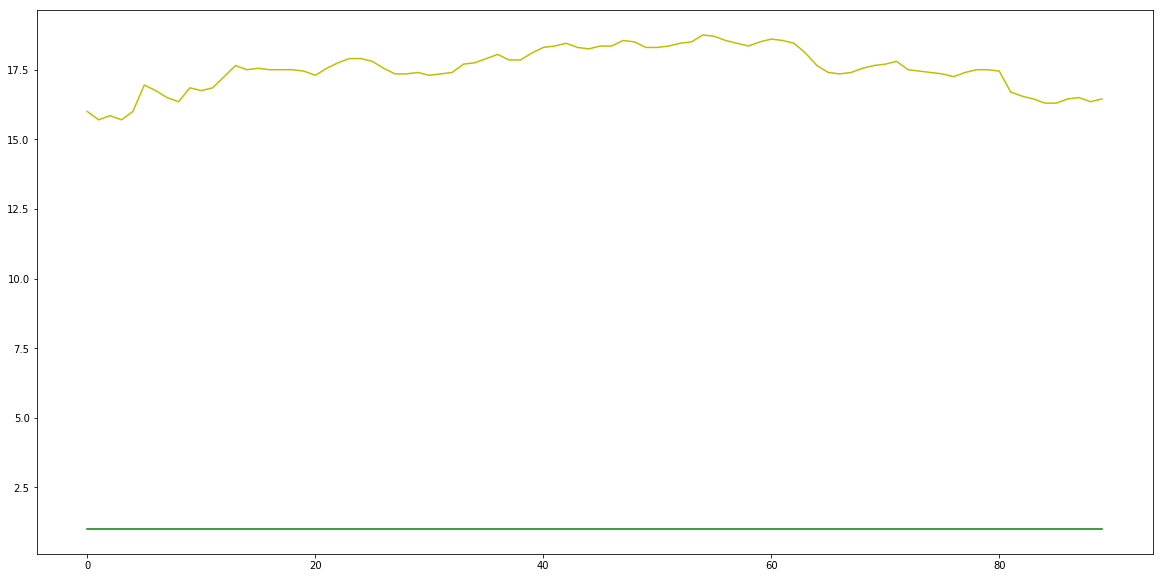

LH


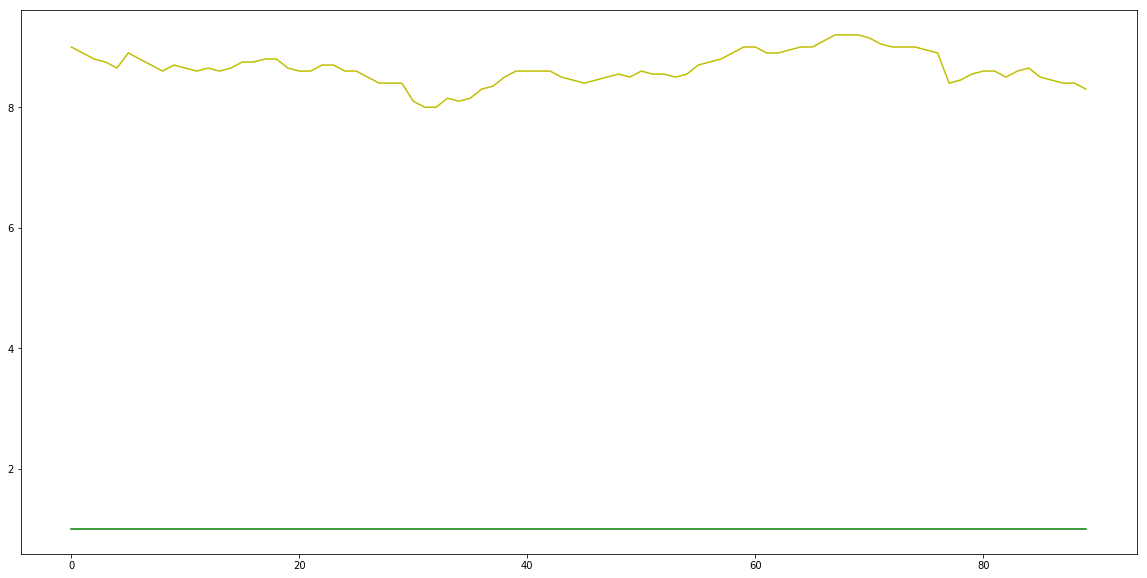

MINT


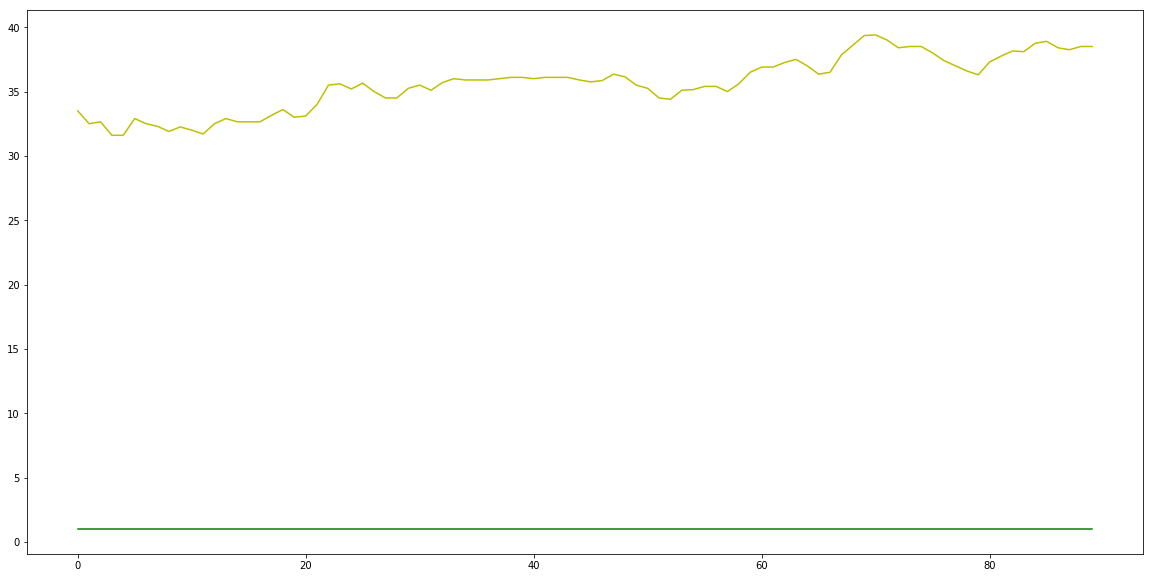

PTT


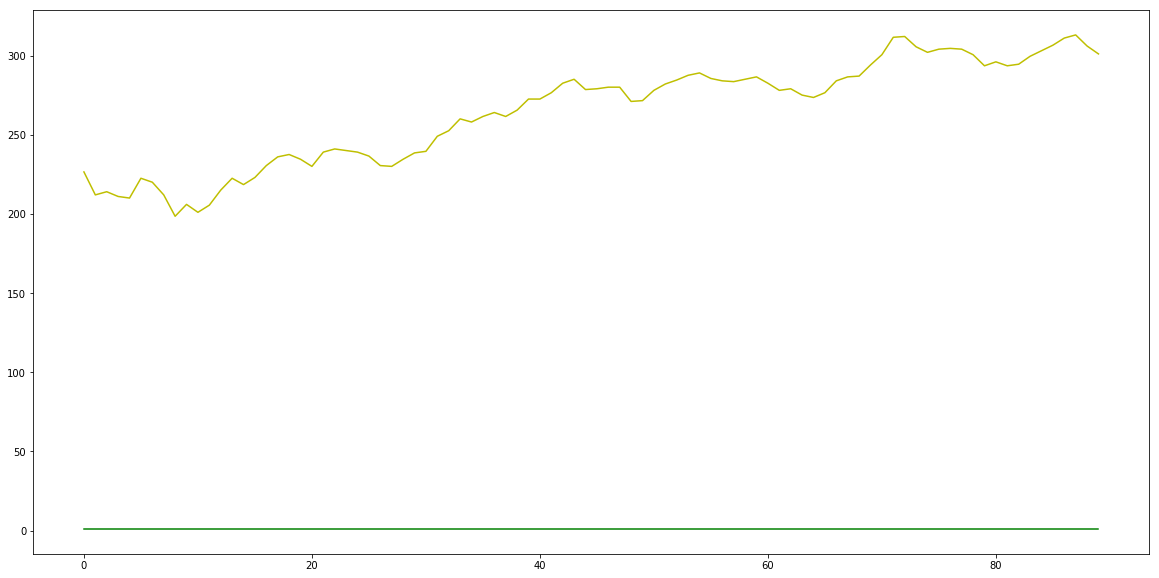

PTTEP


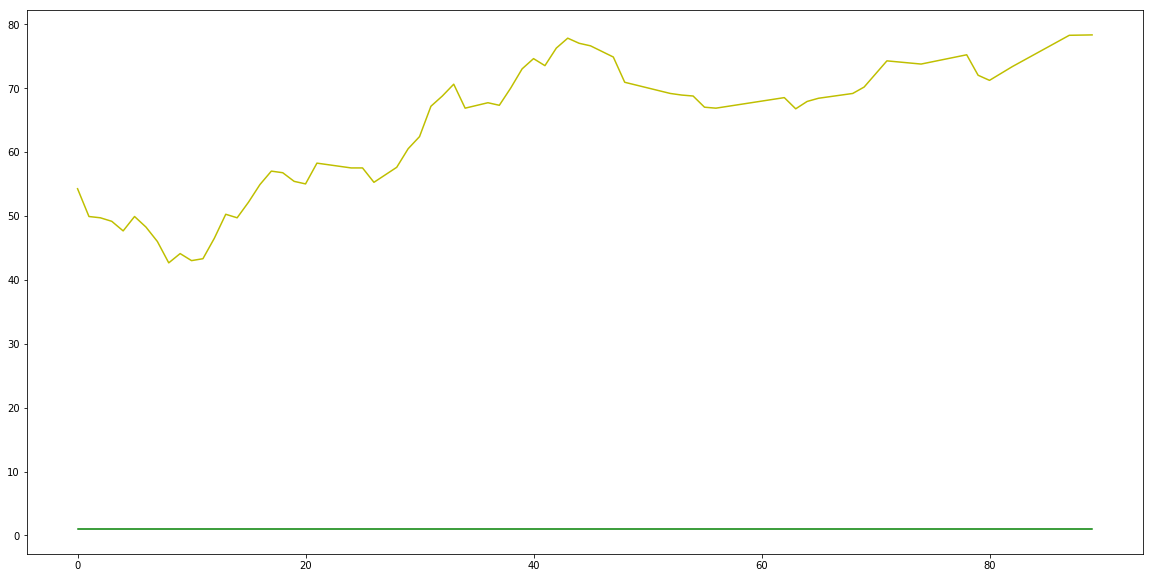

ROBINS


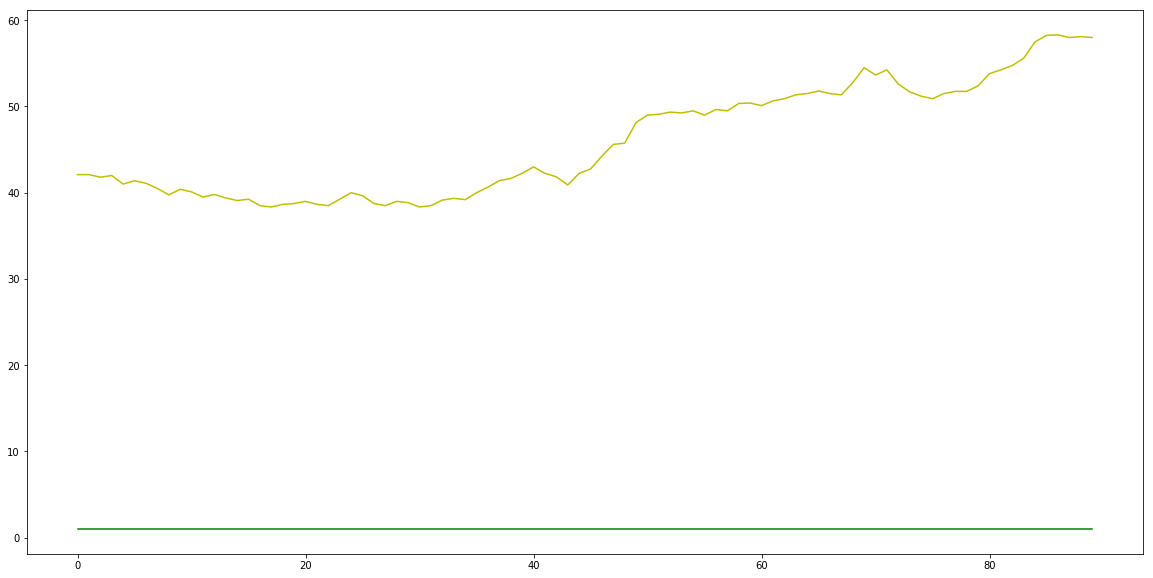

SCB


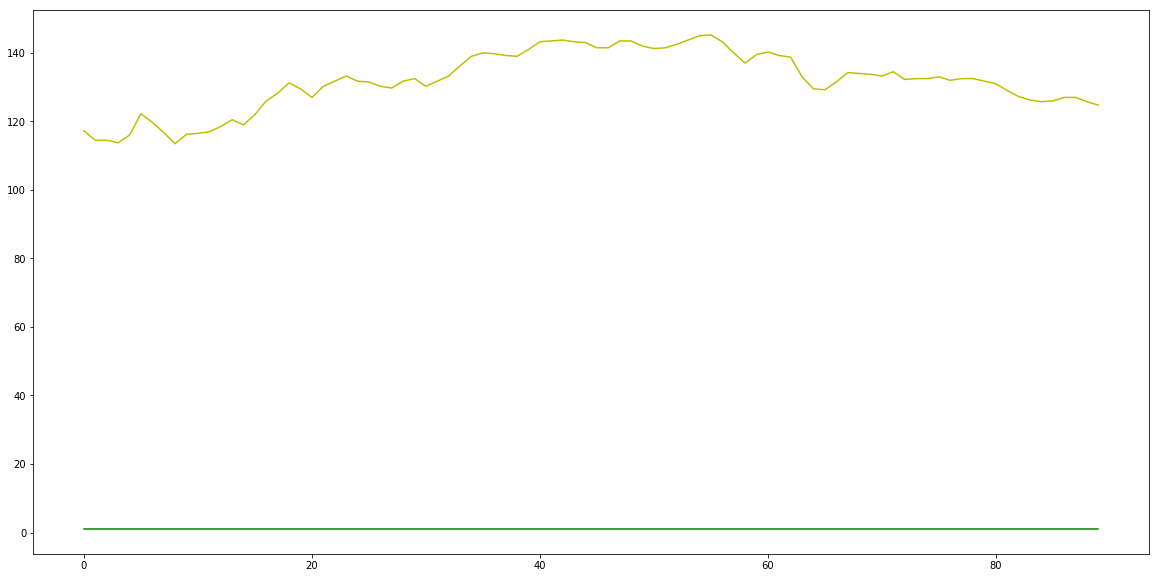

SCC


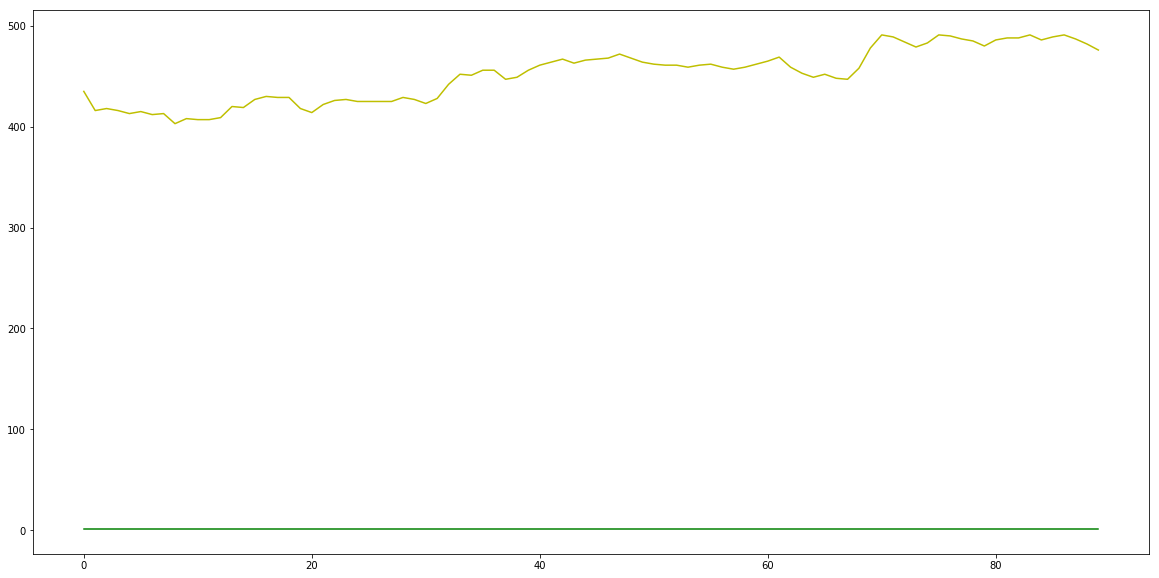

TCAP


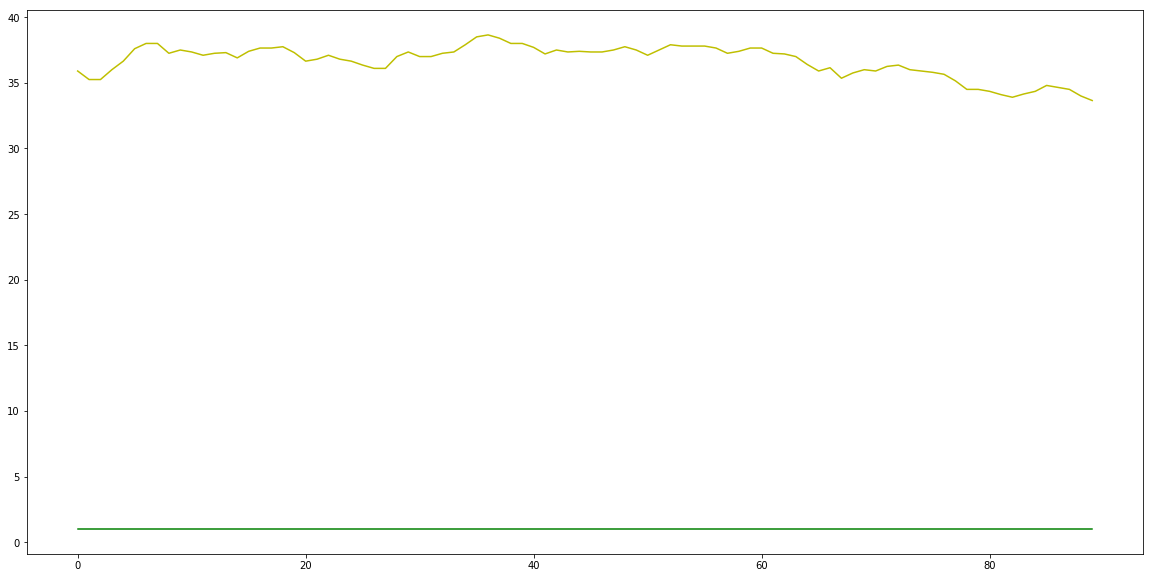

TISCO


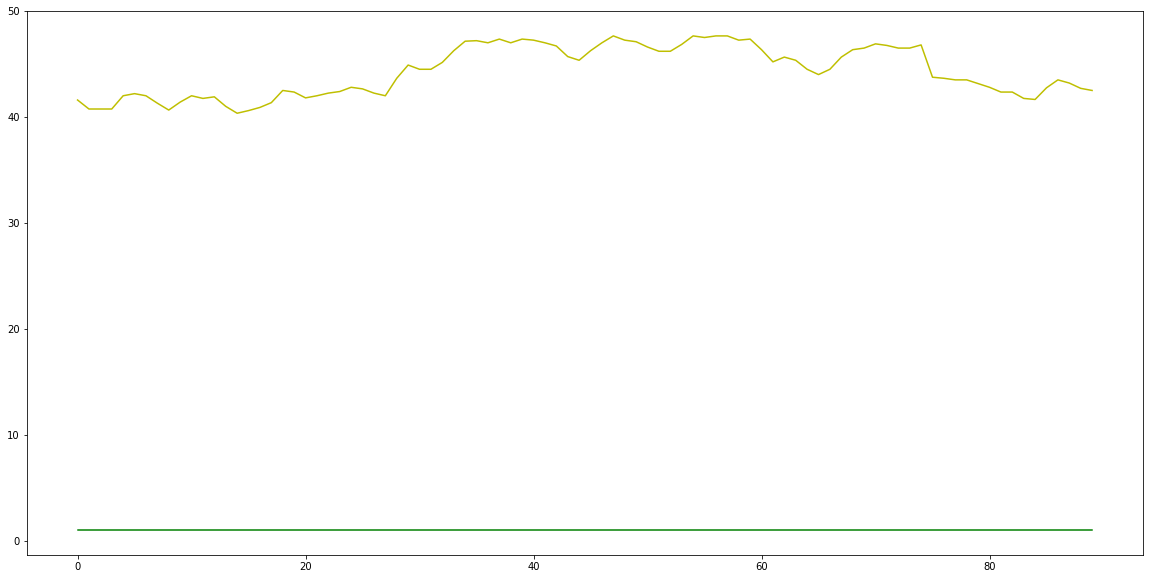

TMB


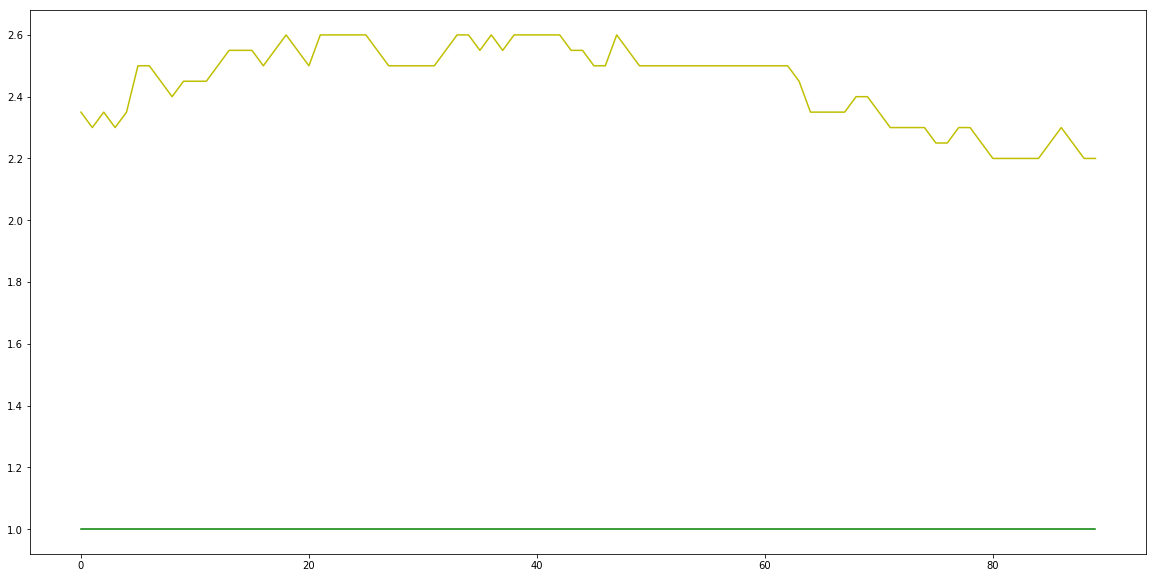

TOP


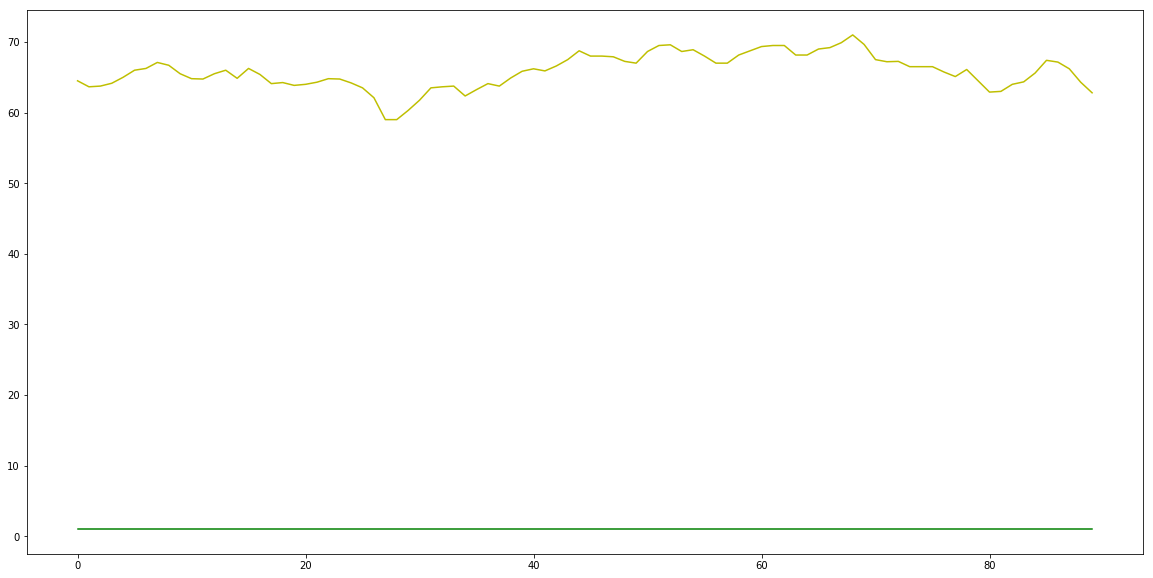

TRUE


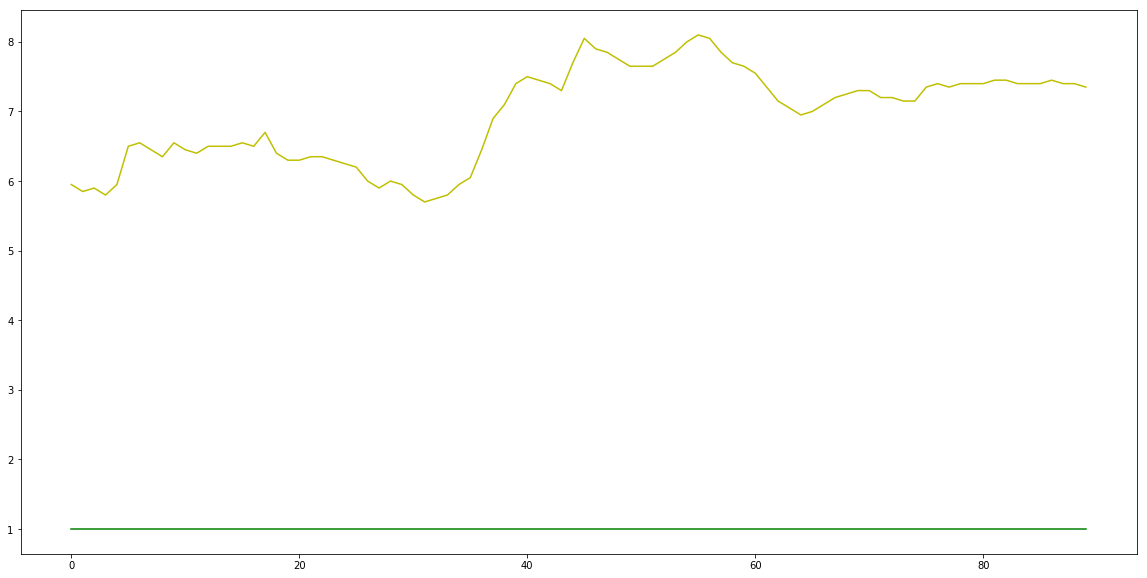

TU


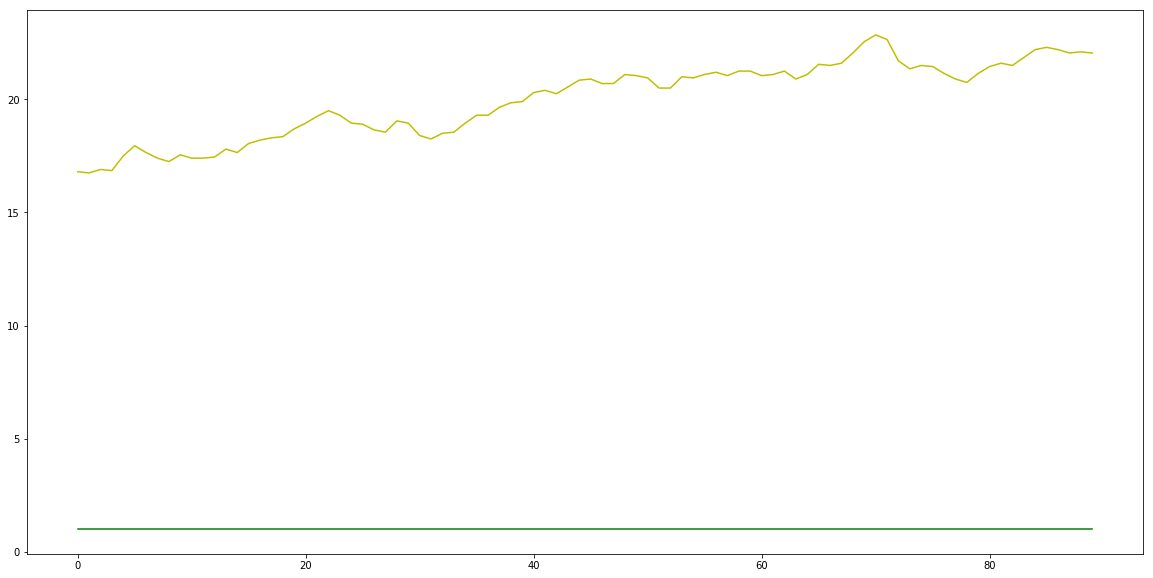

In [36]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[0: 90], i)
    data4 = get_data_from_nparray(y_test[0: 90], i)
    plot_graph(data1, data4)

C:\Users\asus\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
C:\Users\asus\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


LinAlgError: singular matrix

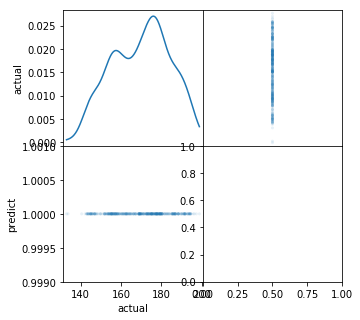

In [37]:
for i in range(len(SET50)):
    d = {'actual': get_data_from_nparray(y_test,i), 'predict': get_data_from_nparray(predicts,i)}
    df = pd.DataFrame(data=d)
    pd.plotting.scatter_matrix(df, diagonal='kde', alpha=0.1,figsize=(5,5))
    plt.suptitle(SET50[i])
    plt.show()